# 1. LOAD ROAD NETWORK DATA

In [2]:
# we will import all the necessary libraries
import pandas as pd
import numpy as np
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import json
import re
from shapely.geometry import Point, LineString #this library is for manipulating geometric objects, and it is what geopandas uses to store geometries
from scipy.spatial import distance

In [3]:
#tlf provides passenger flow data for each network separately
#we need to create a list of all the different files we need
files = ['NBT19MTT2b_od__DLR_tb_wf.csv', 
         'NBT19MTT2b_od__EZL_tb_wf.csv', 
         'NBT19MTT2b_od__LO_tb_wf.csv', 
         'NBT19MTT2b_od__LU_tb_wf.csv']

#create an empty list to store dataframes for each file
dfs = []

#iterate through our files list, read the file and append to our dataframe list
for file in files:
    dfs.append(pd.read_csv('data/' + file))
    
#merge all dataframes
london_OD = pd.concat(dfs, ignore_index=True)

In [4]:
definition_df = pd.read_excel('data/NBT19_Definitions.xlsx', 'Stations')

In [5]:
#we will drop any missing values from our dataframe
definition_df.dropna(inplace=True)

#transform mnlc codes from floats to int
definition_df.MNLC = definition_df.MNLC.astype(int)

In [6]:
#add the station names
london_OD['station_origin'] = london_OD['mode_mnlc_o'].apply(lambda x: definition_df[definition_df.MNLC==x]['StationName'].values[0])
london_OD['station_destination'] = london_OD['mode_mnlc_d'].apply(lambda x: definition_df[definition_df.MNLC==x]['StationName'].values[0])

In [7]:
# we will only keep passenger flows for the timeband we are interested in
london_OD_AMpeak = london_OD[['station_origin', 'station_destination', '3']].copy()

In [8]:
#rename column
london_OD_AMpeak.rename({'3':'flows'}, axis=1, inplace=True)

#since the flows are averages the are stored as flows.
#for our analysis we will turn the into ints
london_OD_AMpeak.flows = london_OD_AMpeak.flows.astype(int)

In [9]:
station_origin = list(london_OD_AMpeak.station_origin.values)
station_destination = list(london_OD_AMpeak.station_destination.values)
all_stations = list(set(station_origin + station_destination))
all_stations = sorted(all_stations, key=str.lower)

In [10]:
london_OD_AMpeak['station_origin']= london_OD_AMpeak.station_origin.apply(lambda x: 
                                      re.sub('\sLU\s?|\sLO\s?|\sNR\s?|\sTf[lL]\s?|\sDLR\s?|\s\(.*\)', '', x)
                                     )
london_OD_AMpeak['station_destination']=london_OD_AMpeak.station_destination.apply(lambda x: 
                                      re.sub('\sLU\s?|\sLO\s?|\sNR\s?|\sTf[lL]\s?|\sDLR\s?|\s\(.*\)', '', x)
                                     )

In [11]:
#group by origin and destination station and sum the flows
london_OD_AMpeak = london_OD_AMpeak.groupby(['station_origin', 'station_destination'], as_index=False).sum()

In [12]:
#let's sanity check and see the highest and lowest flows in and out flows
outflows = london_OD_AMpeak.groupby('station_origin', as_index=False).sum()
#let's sanity check and see the highest and lowest flows in and out flows
inflows = london_OD_AMpeak.groupby('station_destination', as_index=False).sum()

### Load London Underground shapefile data

In [13]:
#read in the data using geopandas
stations = gpd.read_file('data/tfl_stations.json')
lines = gpd.read_file('data/tfl_lines.json')

In [14]:
#project data to British National Grid
#we do this so we can work in meters
stations = stations.to_crs(epsg = 27700)
lines = lines.to_crs(epsg = 27700)

### Clean station names

We have multiple points representing one station (for example Paddington has seperate points for different entrances). We will simplify this by using RegEx make the names consistent. 

Once we have cleaned the names we can set the coordinate of these stations to the mean values of the coordinates of all the stations with the same name.

In [15]:
#get all station names
station_names = {row.id: row['name'] for i, row in stations.iterrows()}

#clean station names
for k, v in station_names.items():
    if k == 'none':
        continue
    cleaned_name = re.sub('\sLU\s?|\sLO\s?|\sNR\s?|\sTf[lL]\s?|\sDLR\s?|\s\(.*\)', '', v)
    
    #note that bank and monument are enconded as one station in our TFL data, so we will do the same
    if cleaned_name in ['Bank', 'Monument']:
        cleaned_name = 'Bank and Monument'
    station_names[k] = cleaned_name
    
stations['name'] = stations['id'].apply(lambda x: station_names[x])

#stations[['name','id']].groupby('name').count().sort_values(by='id',ascending=False)

**Change position of station to mean of all station with the same name**

In [16]:
#get position of stations as mean of x, y of stations

#create empty dict to store list of coordinates
pos = {}

#iterate through the stations
for i, station in stations.iterrows():
    xy = station.geometry.coords[0]
    
    #if station already in dict add coordinate to coordinate list
    if station['name'] in pos.keys():
        pos[station['name']].extend([xy])
    #if station is not in the dict add station to dict and set first coordinate in list
    else:
        pos[station['name']] = [xy]

#iterate through our dict and replace coordinate list with mean value
for k, v in pos.items():
    #we set axis to 0 to make sure to take mean of x and y coordinates
    pos[k] = np.mean(v, axis=0)

In [17]:
#set new geometry
stations['geometry'] = stations['name'].apply(lambda x: Point(pos[x]))

### Lines file

In [18]:
#get all line types as a list and subset geoms by lines
line_names  = lines.lines.apply(lambda x: [x['name'] for x in json.loads(x)] )
line_names = list(set([item for sublist in line_names for item in sublist]))

In [19]:
#We can see that east london line is incomplete
#digging into this however we notice that it's because east london is actually part of the overground
#merge East London line and London Overground since they are one line
lines.lines = lines.lines.str.replace('East London', 'London Overground')
stations.lines = stations.lines.str.replace('East London', 'London Overground')

In [20]:
#Our TFL data doesn't include tramlink, emirates air lines, and crossrail is still in construction (except not really)
#exclude the lines that we are not going to use
excluded_lines = ['Thameslink 6tph line', 'East London', 'Crossrail 2', 'Emirates Air Line', 'Crossrail', 'Tramlink']

## Create seperate graphs for each line and then join

Since we don't have properly constructed line geometries because:
* there are discontinuities in the line geometries
* a line between two stations can actually be composed of more than one geometry

We will construct geometric graphs (meaning graphs just from the line geometries where nodes are coordinates that define the line geometry). It's easy to fix the discontinuities in this manner because the can be thought of as nodes with degree = 1 that have another node with degree = 1 within a threshold distance. 

Once we have these discontinuties fixed we can use these geometric graphs to construct proper geometries between stations by taking the shortest paths within these networks starting from the node closest to the origin station and ending in the node closest to the destination station. The shortest path will then be a list of coordinates that define the line geometry between the two stations. 

Piccadilly


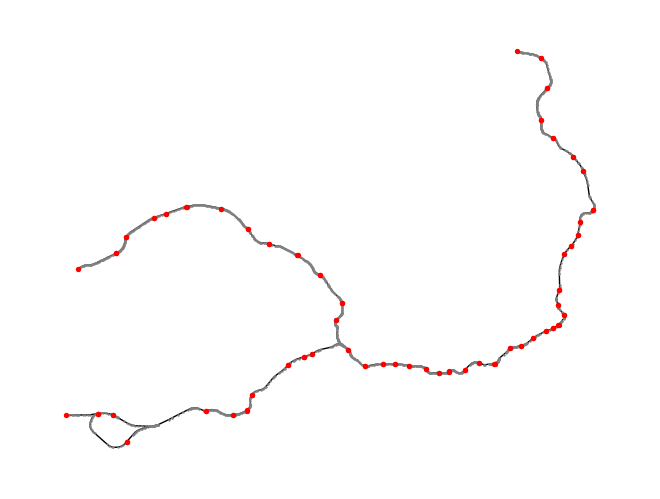

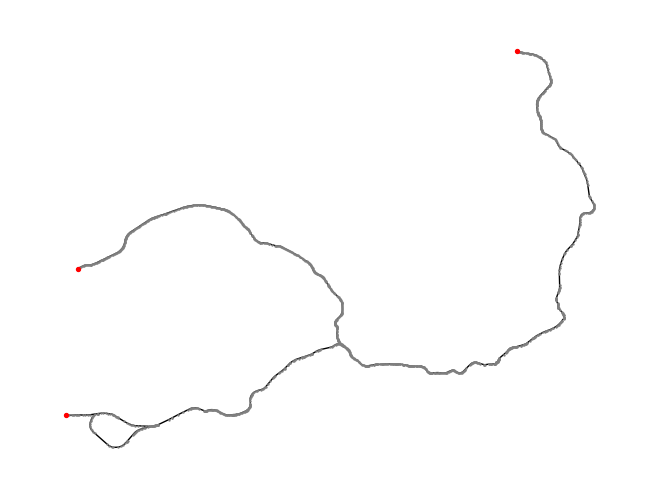

1
Metropolitan


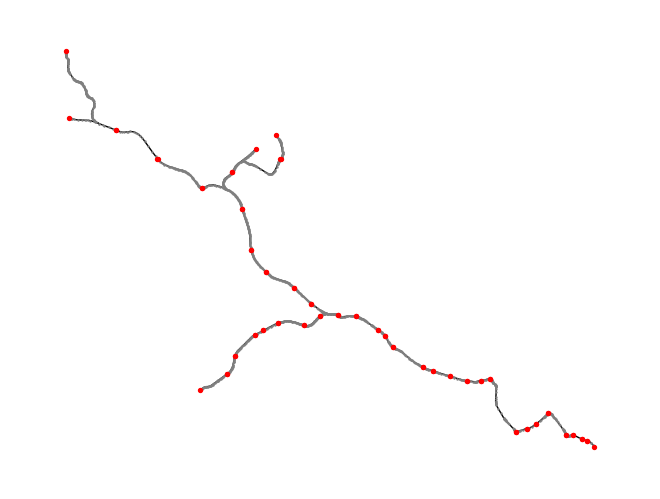

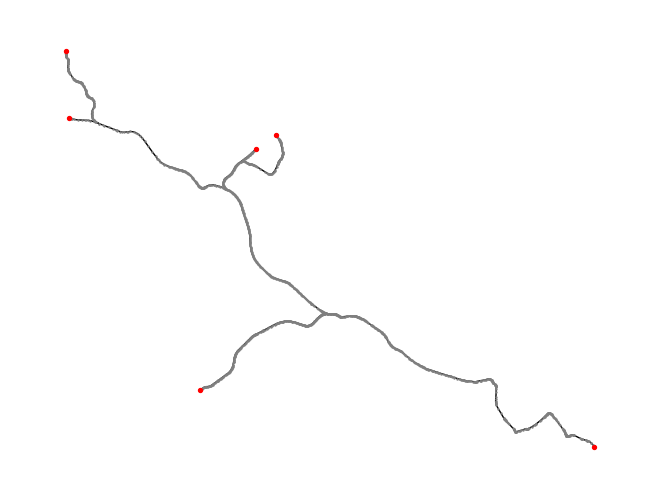

1
Hammersmith & City


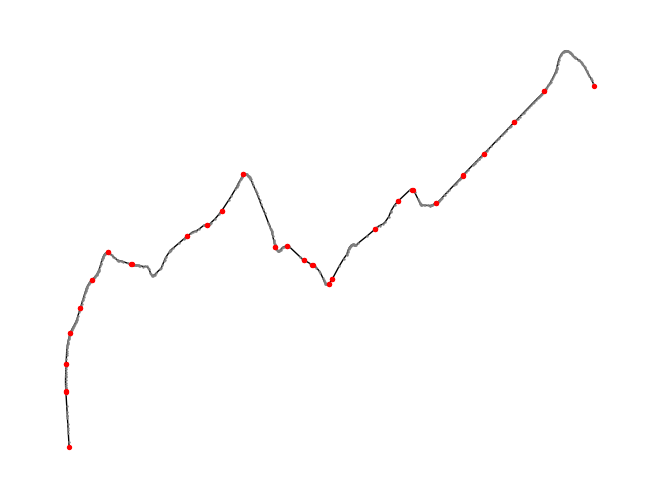

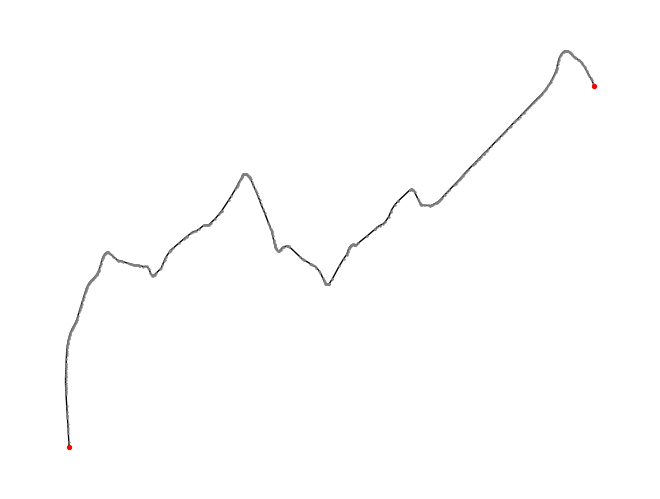

1
Victoria


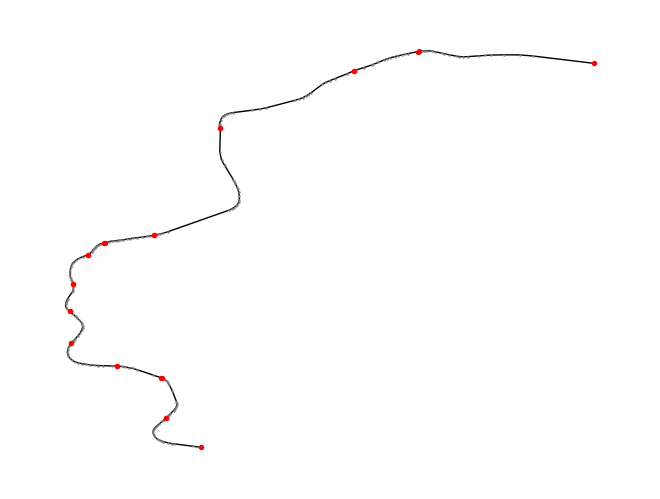

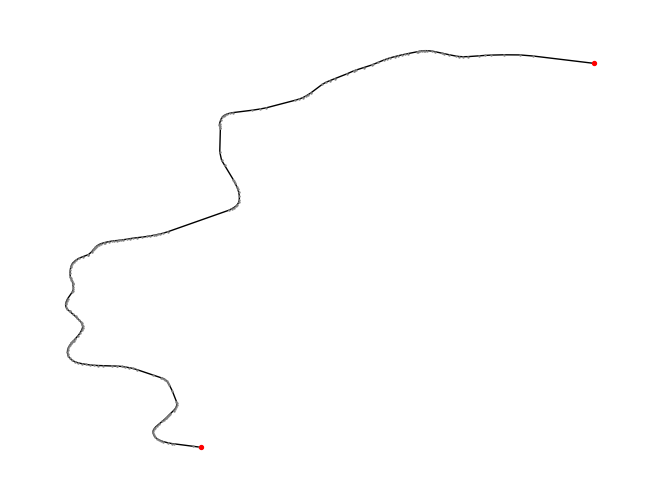

1
Waterloo & City


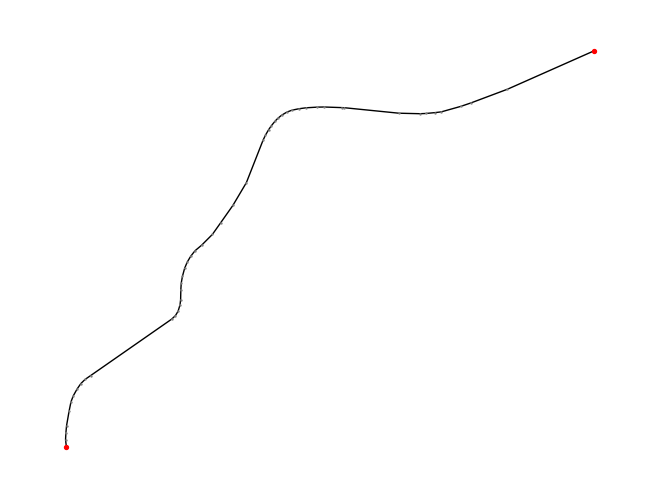

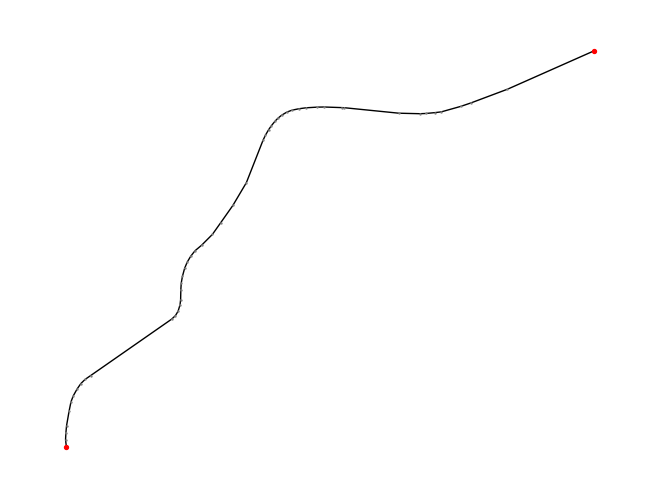

1
DLR


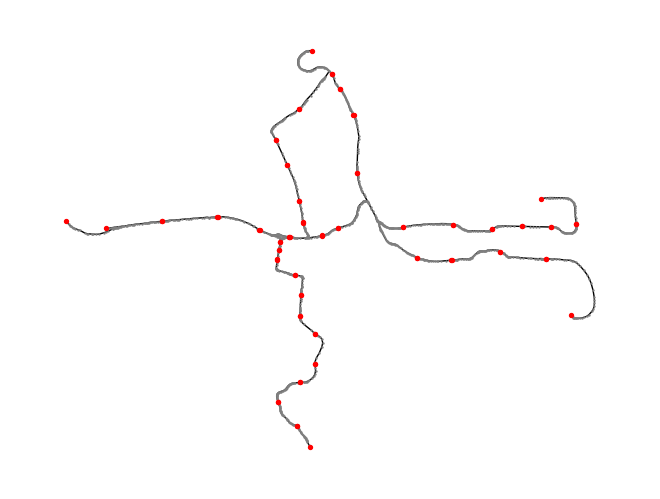

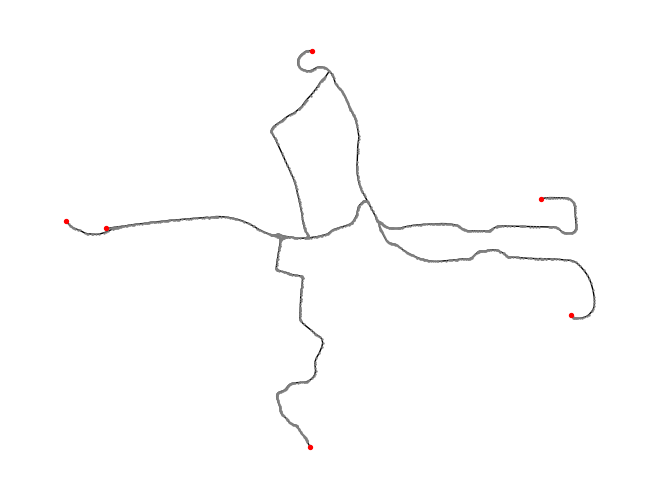

1
District


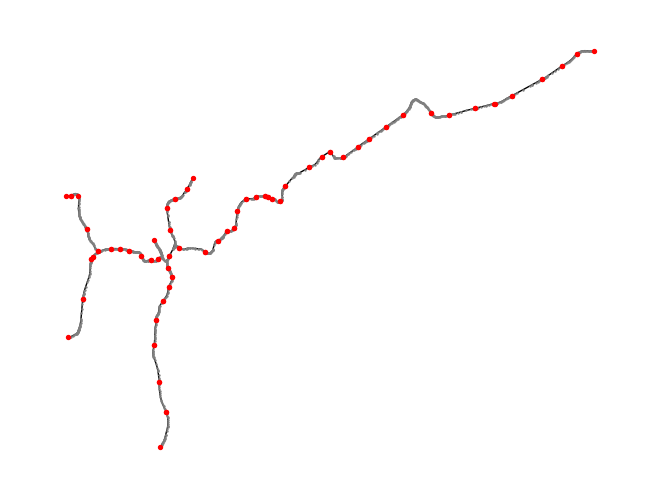

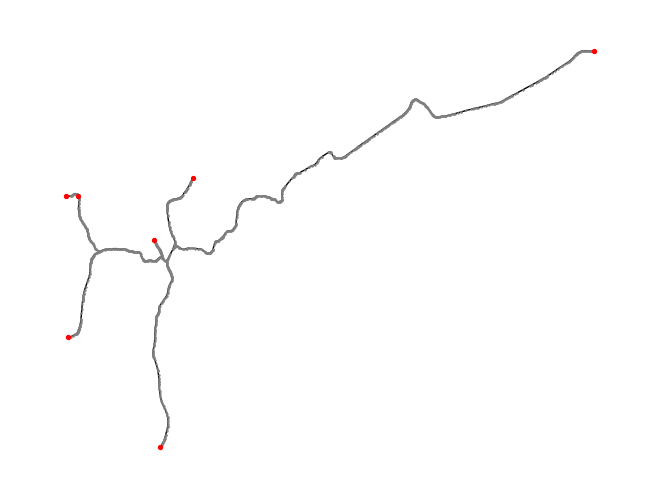

1
TfL Rail


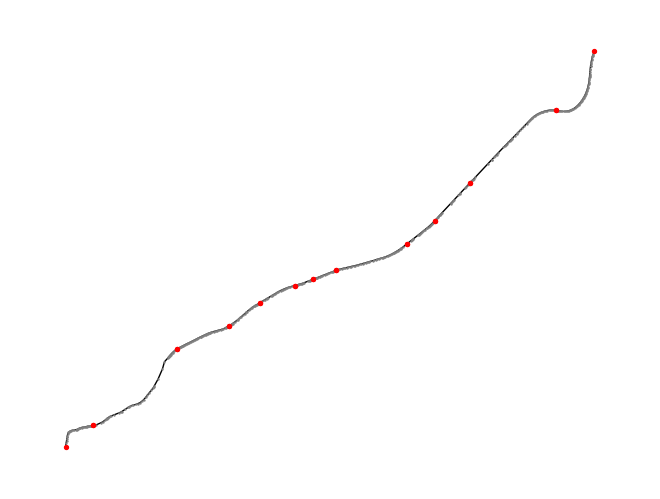

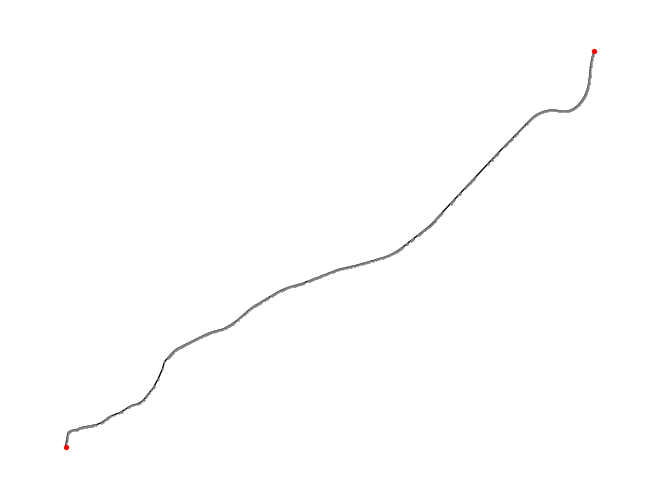

1
Bakerloo


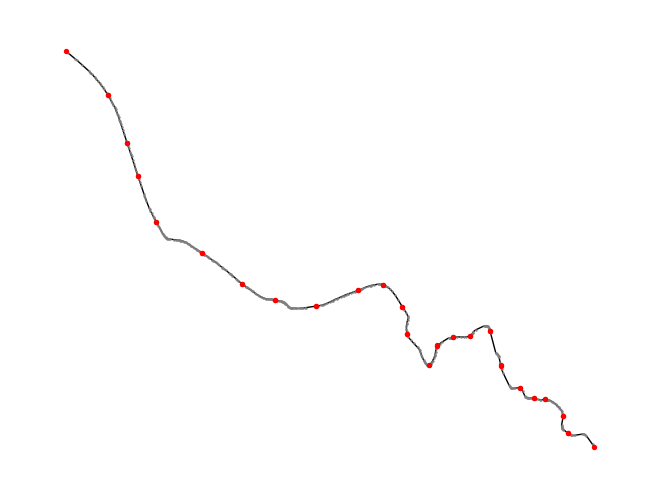

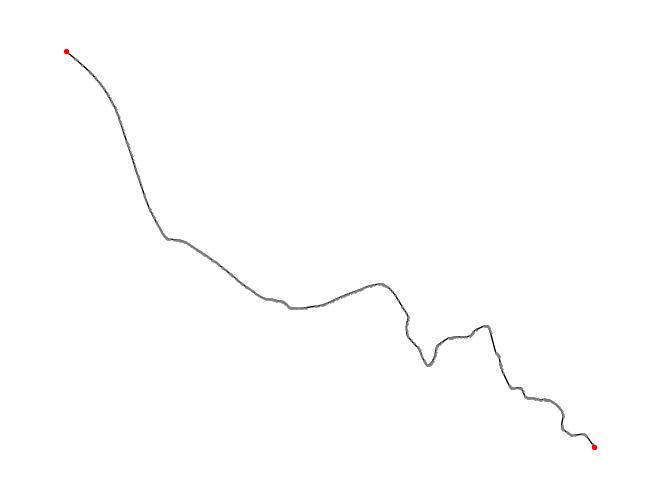

1
Central


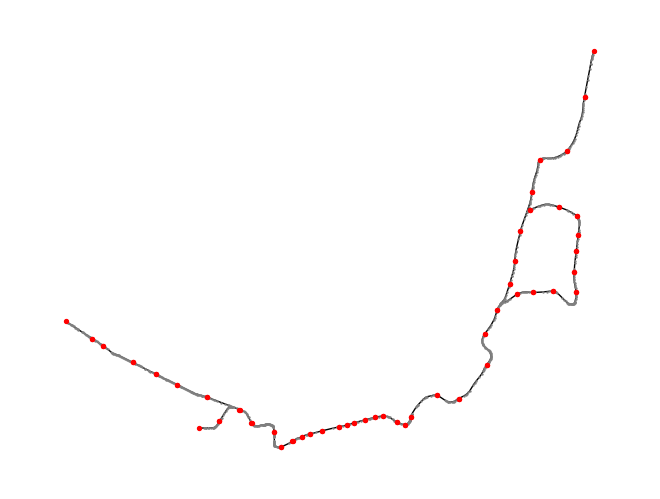

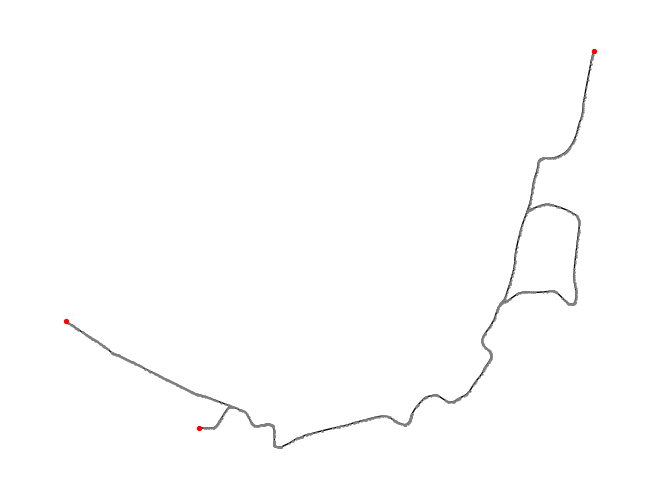

1
Jubilee


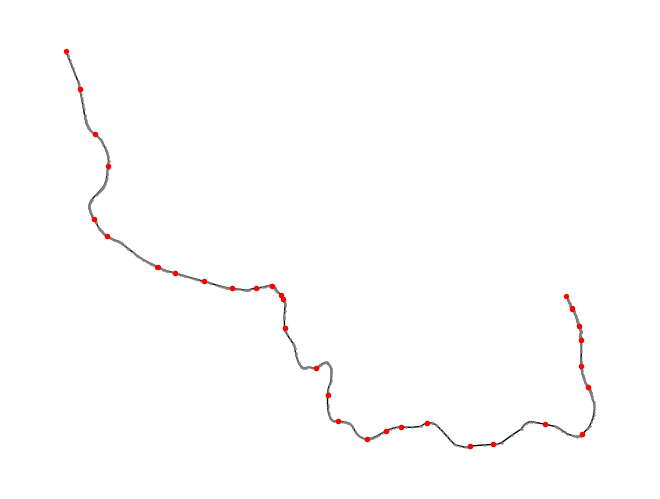

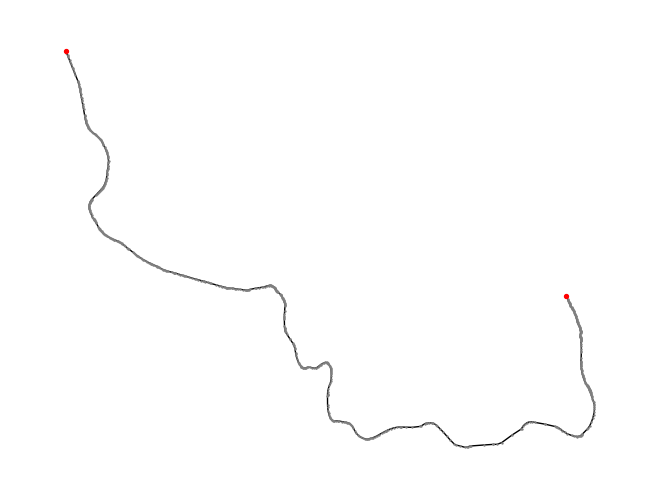

1
Northern


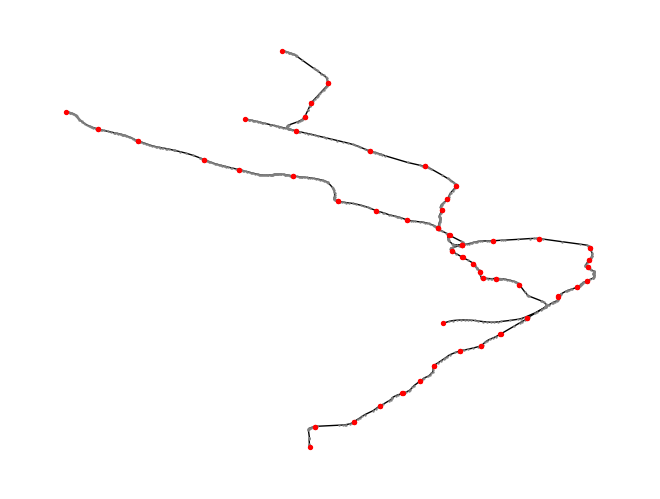

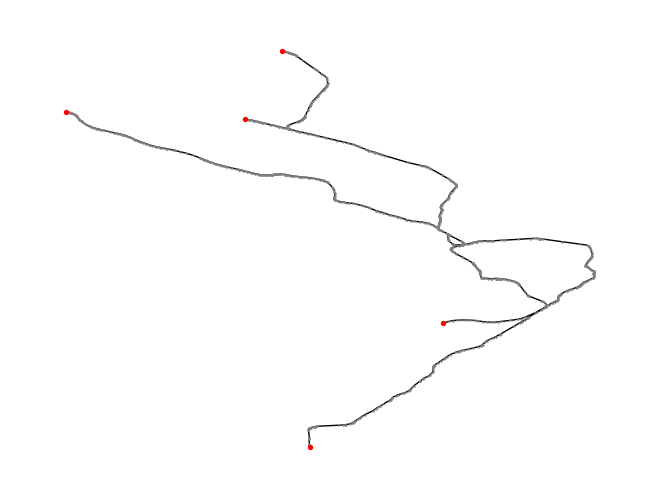

1
Circle


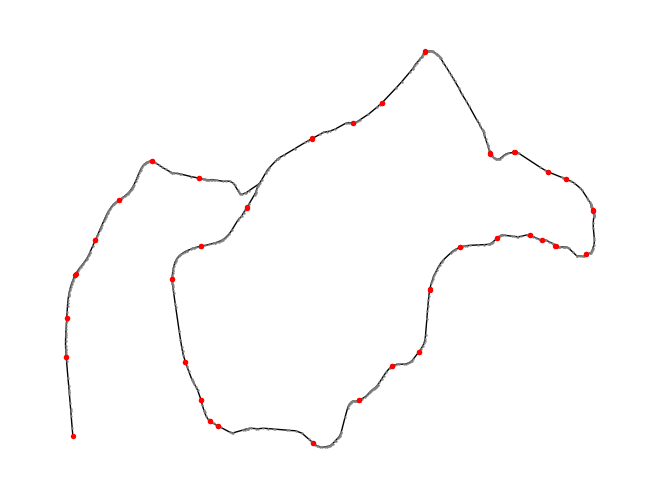

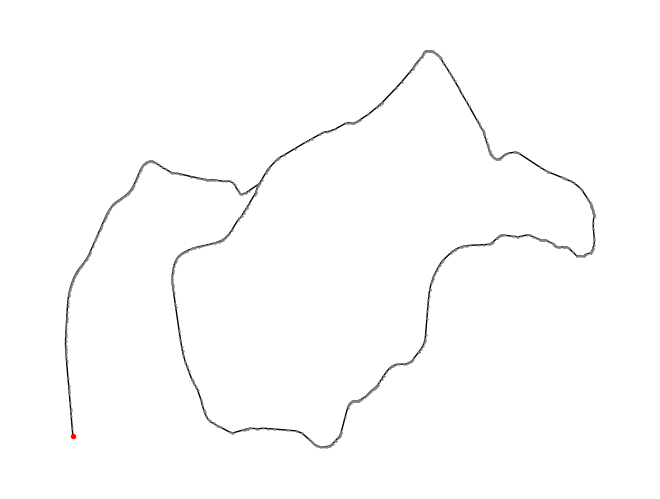

1
London Overground


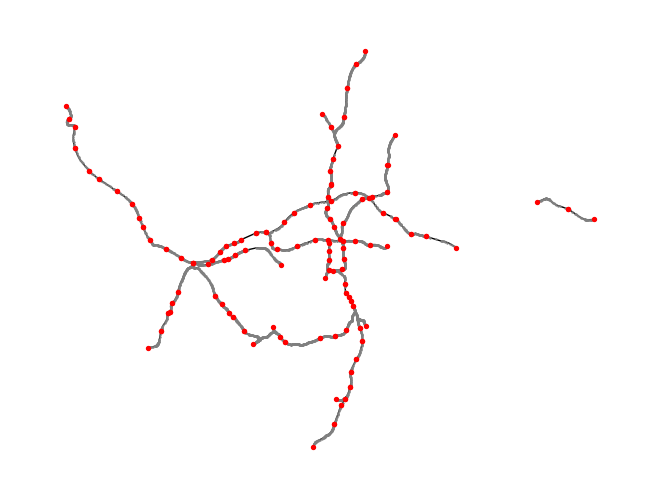

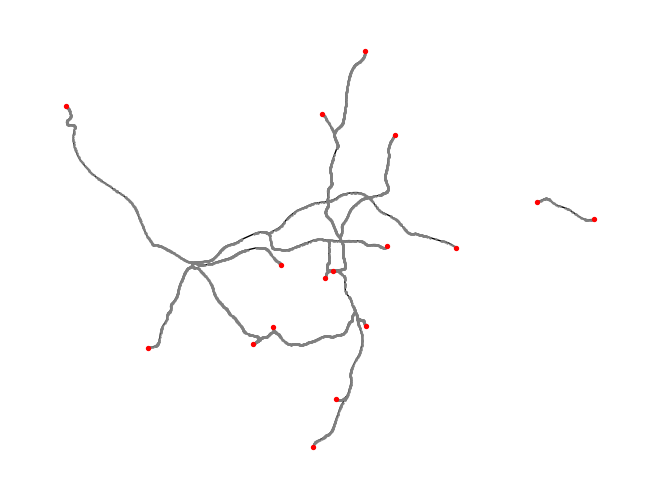

3


In [21]:
#create an empty dict to hold our geometric graphs
geometric_graphs = {}

#iterate through each line individually
for line_name in line_names:
    #skip lines that we won't be using
    if line_name in excluded_lines :
        continue
    print(line_name)
    
    #subset our line and station files for the ones the belong to a specific line
    temp_lines = lines[lines.lines.str.contains(line_name)]
    temp_stations = stations[stations.lines.str.contains(line_name)]
    
    #create empty graph
    G= nx.Graph()
    
    #iterate through our line geometries
    for i, line in temp_lines.iterrows():
        #get list of coordinates that define our line
        _l = list(line.geometry.coords)

        #add coordinates as edges
        G.add_edges_from(list(zip(_l,_l[1:])))
    
    #remove any self loops
    G.remove_edges_from(nx.selfloop_edges(G))
    
    #the position of the node is the name of the node
    #let's extract this to plot our graph
    pos = {n: n for n in G.nodes()}
    
    # get degree one nodes
    D = nx.degree(G)
    k1 = [node for node,degree in D if degree==1]
    #let's plot our graph and all degree one nodes
    nx.draw(G, pos=pos, node_size=0.5, node_color='grey')
    nx.draw_networkx_nodes(G, pos=pos, nodelist=k1, node_color='red', node_size=8)
    plt.show()
    
    #get distance between all points of 1-degree, this will be a matrix
    dist = distance.cdist(k1, k1)
    
    #add edges between points that are close
    for j in range(dist.shape[0]-1):
        temp = dist[j][j+1:]
        #get index of closest node
        i_min = np.argmin(temp)
        if dist[j][i_min+j+1]<50:
            G.add_edge(k1[j],k1[i_min+j+1])
    
    #recalculate degree
    D = nx.degree(G)
    k1 = [node for node,degree in D if degree==1]
    #plot new graph
    nx.draw(G, pos=pos, node_size=0.5, node_color='grey')
    nx.draw_networkx_nodes(G, pos=pos, nodelist=k1, node_color='red', node_size=8)
    plt.show()
    print(nx.number_connected_components(G))
    #store graph in dictionary
    geometric_graphs[line_name] = G


Now that we have these geometric graphs we can create our final graph by using the data in the lines attribute in our lines geodataframe that contains origin and destination station. We can then use our geometric graph and find the shortest route to create our line geometries and find the length of the lines. 

We will store this information in a dataframe that we can use to create our final graph

In [22]:
#create a dataframe with all geometries from all valid lines
#this list will contain a dictionary for each edge in our graph that contains
# node pairs, line name, and a geometry (this is just for quick visualization purposes and will be replaced by true geometry)
edge_list = []
def _has_ids(k):
    #helper function to check if line contains id of start and end station
    if ('start_sid' in k.keys()) and ('end_sid' in k.keys()):
        return True
    else:
        return False

#iterate through each line seperately 
for line_name in line_names:
    if line_name in excluded_lines :
        continue
        
    #subset lines and stations
    temp_lines = lines[lines.lines.str.contains(line_name)]
    temp_stations = stations[stations.lines.str.contains(line_name)]
    
    #for each line in our subset dataframe get each origin and destination pair
    for i, line in temp_lines.iterrows():
        for k in json.loads(line.lines):
            if k['name'] == line_name:
                if _has_ids(k):
                    #get start and end station ids
                    start_id = k['start_sid']
                    end_id = k['end_sid']

                    #get info of start and end station
                    start_station = temp_stations[(temp_stations.id == start_id) | (temp_stations.altmodeid == start_id)].values
                    end_station = temp_stations[(temp_stations.id == end_id) | (temp_stations.altmodeid == end_id)].values
                    
                    #if no matching station exist, let's just take the starting and ending coordinate of the line for now
                    if len(start_station) >= 1 and len(end_station) >=1:
                        s_geom = start_station[0][-1].coords[0]
                        e_geom = end_station[0][-1].coords[0]
                        edge_list.append({
                            'line_name': line_name,
                            'start_id': start_id,
                            'end_id': end_id,
                            'geometry': LineString([s_geom, e_geom])
                        })

In [23]:
#turn our dictionary list into a geopandas df to quickly plot and sanity check our work
edge_gdf = gpd.GeoDataFrame(edge_list)
edge_gdf.crs = lines.crs

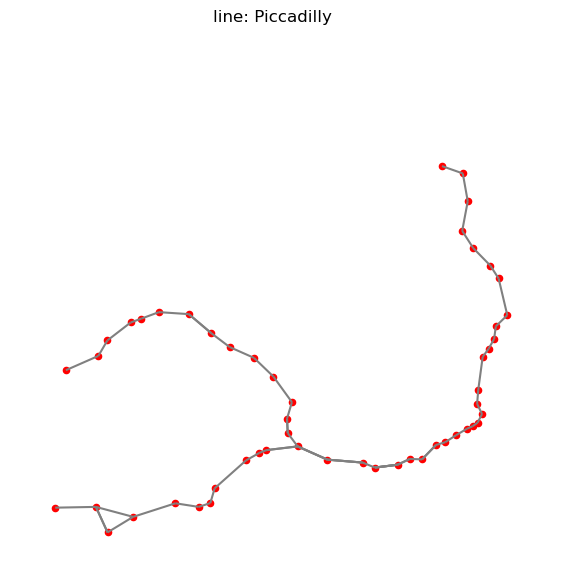

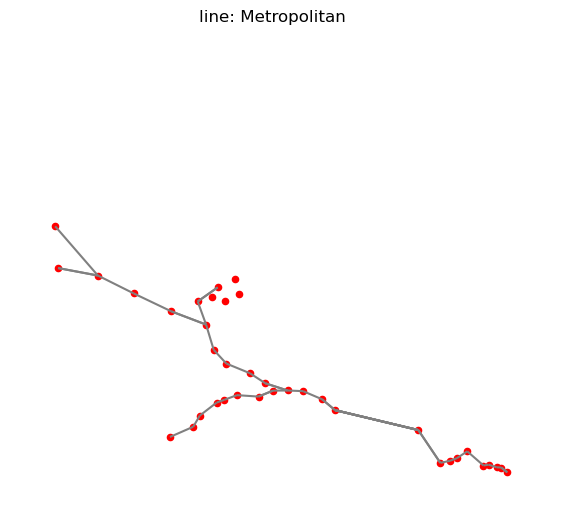

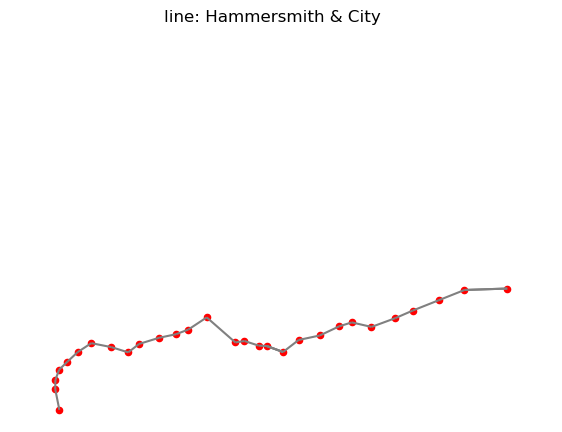

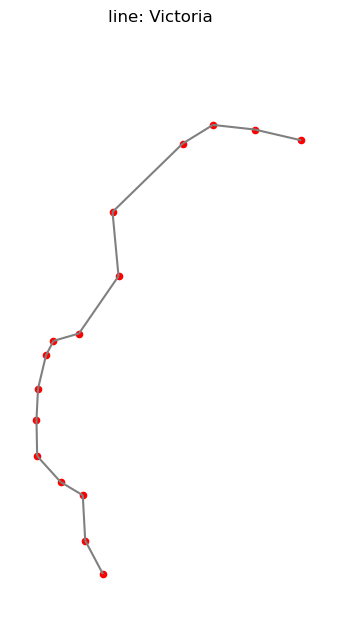

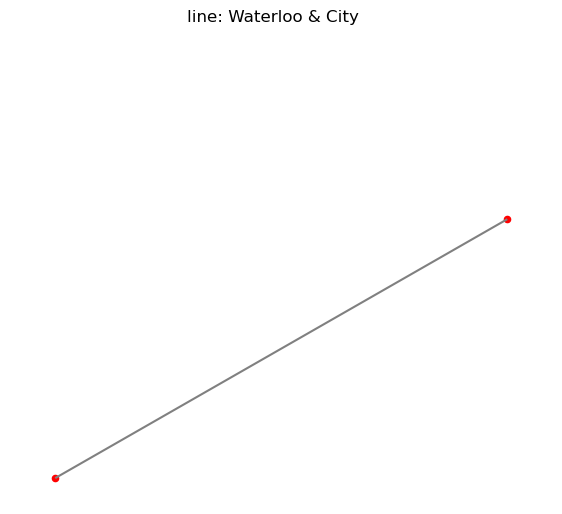

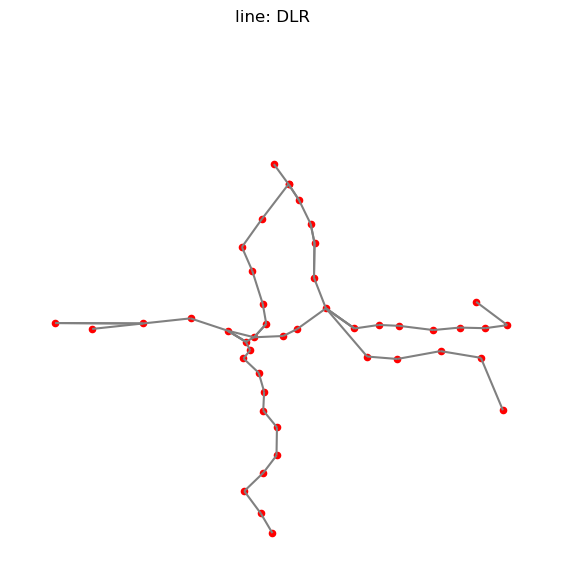

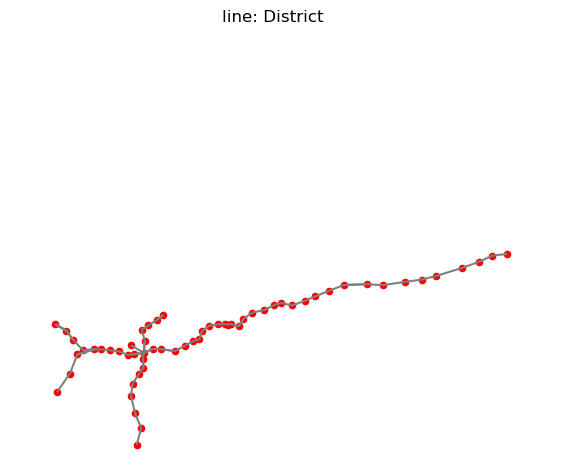

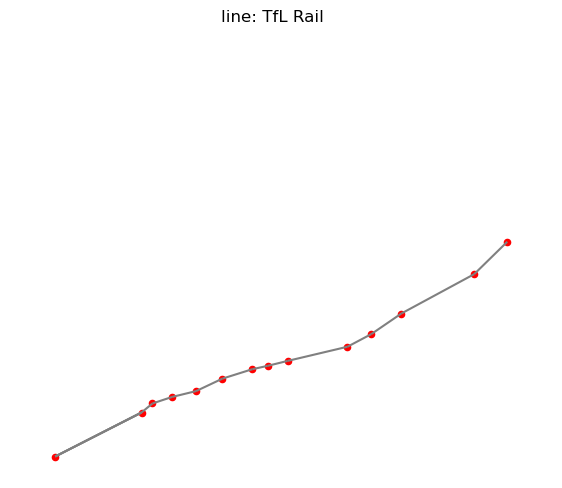

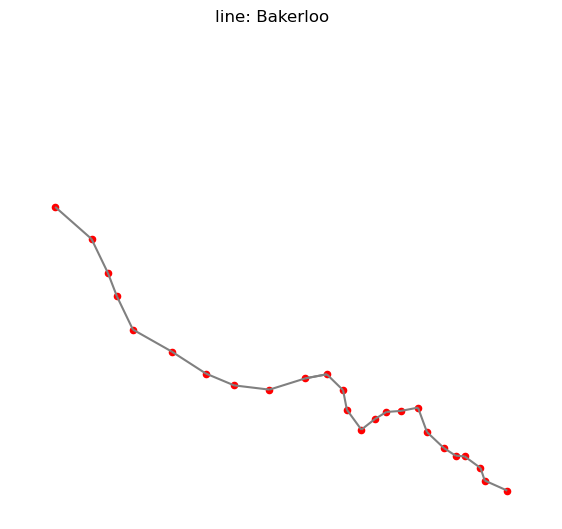

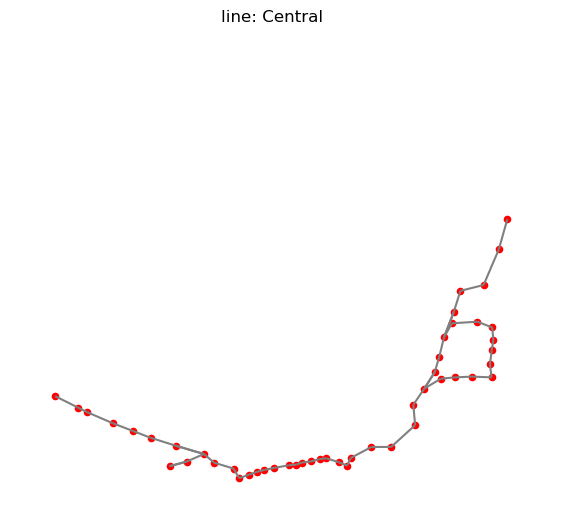

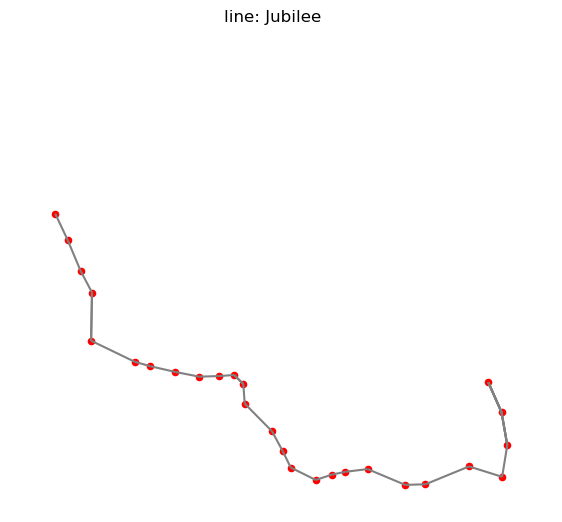

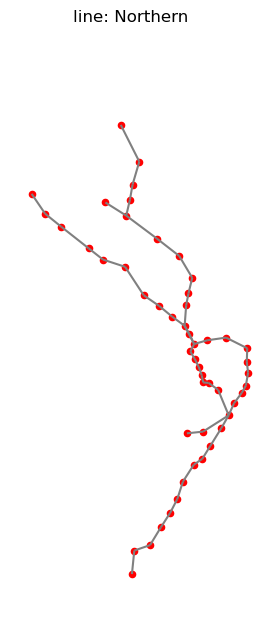

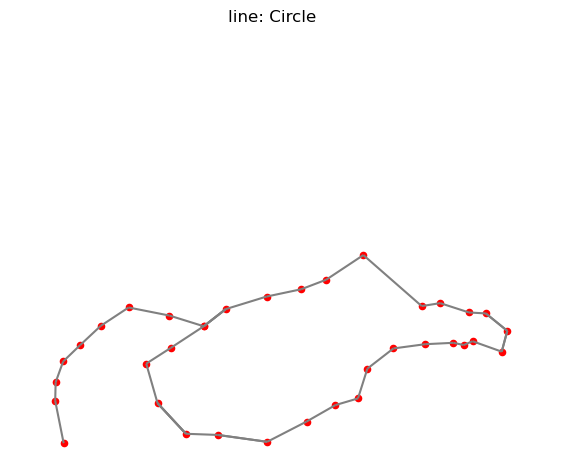

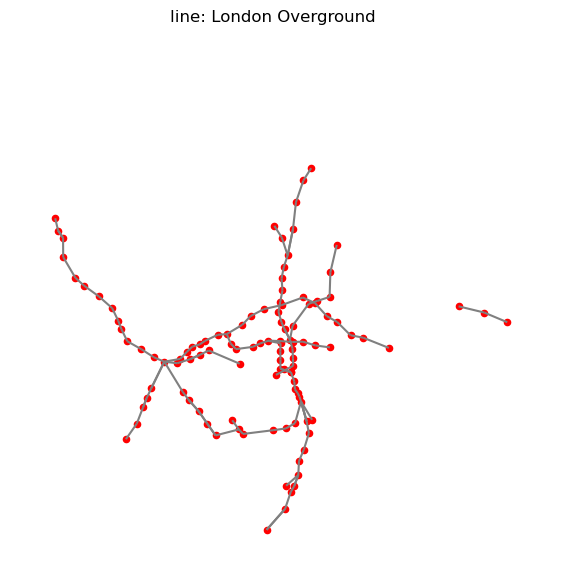

In [24]:
### Add geometry information back into the graph
for line_name in line_names:
    if line_name in excluded_lines :
        continue
    temp_lines = edge_gdf[edge_gdf.line_name == line_name]
    temp_stations = stations[stations.lines.str.contains(line_name)]
    
    #let's plot our lines so we can check them
    fig, ax = plt.subplots(figsize = (7,7))
    fig.suptitle(f'line: {line_name}')
    ax.set_aspect("equal")
    ax.axis('off')
    ax.margins(0.1)
    
    base = temp_lines.plot(ax=ax, color='grey')
    temp_stations.plot(ax=base, markersize=20, color='red')
    plt.show()
    
    #add real geometry back
    for i, edge in temp_lines.iterrows():
        #get start and end of line coordinates
        start = edge.geometry.coords[0]
        end = edge.geometry.coords[-1]
        
        #let's get all the coordinates in our geometric graph
        nodes = list(geometric_graphs[line_name].nodes)
        
        #find nearest node in graph to origin and destination
        s_dist = distance.cdist([start], nodes)[0]
        s_i = np.argmin(s_dist)
        source= nodes[s_i]
        
        t_dist = distance.cdist([end], nodes)[0]
        t_i = np.argmin(t_dist)
        target= nodes[t_i]
        
        #get shortest path
        sp = nx.shortest_path(geometric_graphs[line_name], source, target)
        
        #make into geometry
        #notice how I'm also adding the start and end coordinates to the line definition
        #this fixes the problem of stations and lines not matching up
        geometry = LineString([start] + sp + [end])
        edge_gdf.loc[i, 'geometry'] = geometry

In [25]:
#let's store the length of the real geometry
edge_gdf['length'] = edge_gdf.geometry.length

In [26]:
#let's replace the ids with the actual name
#get all station names
station_names_2 = {row.altmodeid: row['name'] for i, row in stations.iterrows() if row.altmodeid != None}
station_names.update(station_names_2)

In [27]:
edge_gdf['start_id'] = edge_gdf['start_id'].apply(lambda x: station_names[x])
edge_gdf['end_id'] = edge_gdf['end_id'].apply(lambda x: station_names[x])

## IMPORTANT!!!

{'Circle', 'Metropolitan', 'London Overground', 'Hammersmith & City', 'TfL Rail', 'Victoria', 'Bakerloo', 'Central', 'Waterloo & City', 'Jubilee', 'Piccadilly', 'DLR', 'District', 'Northern'}


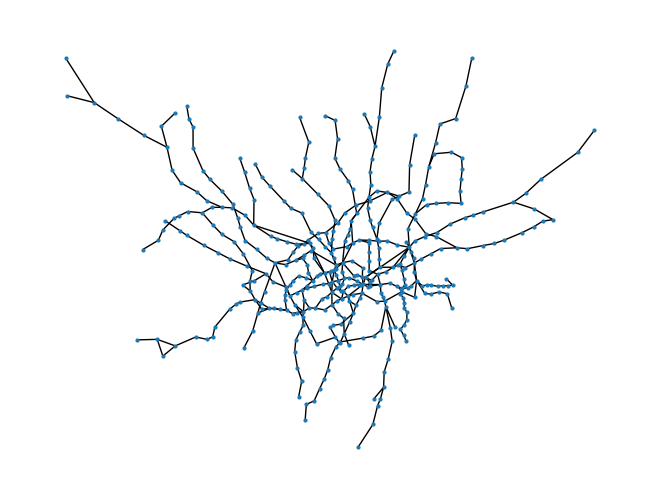

In [28]:
#now we can use this to create our network!
G = nx.from_pandas_edgelist(edge_gdf, source = 'start_id', target='end_id', edge_attr=['length', 'line_name'])

#let's plot
#notice that even though we created the real geometries, the graph still plots just straight line
#this is because networkx doesn't have a concept of a edge geometry
#however this is ok, since we only need the distance as weights, and that is already an attribute in our graph
pos = {row['name']: row.geometry.coords[0] for i, row in stations.iterrows() if row['name'] in G.nodes()}
Gcc = nx.connected_components(G)
for n in Gcc:
    G_sub = G.subgraph(n)
    lines = [data['line_name'] for u,v, data in G_sub.edges(data=True)]
    print(set(lines))
    nx.draw(G_sub, pos, node_size=4)
    plt.show()

#save position to graph
nx.set_node_attributes(G, pos, 'coords')

### Sanity check our network

In [29]:
#check that all distances are greater or equal to euclidean distance
for u,v, data in G.edges(data=True):
    assert(data['length'] >= distance.euclidean(pos[u], pos[v]))

In [30]:
#if want to know what is the maximum distance between stations
max(dict(G.edges).items(), key=lambda x: x[1]['length'])

(('Wembley Park', 'Finchley Road'),
 {'length': 7266.373927496486, 'line_name': 'Metropolitan'})

In [31]:
#if want to know to which stations Baker Street is directly connected to
Baker_Street = [(u,v) for  u,v in G.edges() if u == 'Baker Street' or v == 'Baker Street']
Baker_Street

[('Baker Street', 'Great Portland Street'),
 ('Baker Street', 'Finchley Road'),
 ('Baker Street', 'Edgware Road'),
 ('Baker Street', 'Marylebone'),
 ('Baker Street', "Regent's Park"),
 ('Baker Street', 'Bond Street'),
 ('Baker Street', "St. John's Wood")]

In [32]:
#We can also check the degree of the nodes in our network and check that they make sense
deg_london = nx.degree(G)

In [33]:
df = pd.DataFrame(index = dict(deg_london).keys())
df['degree'] = dict(deg_london).values()

In [34]:
df.sort_values('degree', ascending =False).head(20)

,degree
Stratford,9
Bank and Monument,8
Baker Street,7
King's Cross St. Pancras,7
Earl's Court,6
Green Park,6
Canning Town,6
Oxford Circus,6
West Ham,6
Liverpool Street,6


### Merge Network with OD data

ok, we are almost done!

We have processed our raw data, now we need to combine the two (TLF OD and our Network). For this we need two types of merge:

1. add flows as weights to the network (to be able to calculate disruptions to the network)
2. create OD with distance for our spatial interaction models (for our spatial interaction models)

In [35]:
#check that our OD data and network data match
OD_names = set(london_OD_AMpeak.station_origin.unique())
network_names = set([n for n in G.nodes()])

Ok, we have a few stations that don't match up. They are small enough that we can solve this quickly by creating a mapping between names of the stations that we can keep.

* Battersea power station and Nine Elms data doesn't exist in our TFL data because the station wasn't opened when the data was collected. This was an extension of Northern line that opened recently.
* Action Main Line, Hanwell, Hayes & Harlington, Southall, and West Ealing are part of crossrail which we are not considering

In [36]:
name_map = {
    'Heathrow Terminal 4 EL': 'Heathrow Terminal 4',
    'Heathrow Terminals 123': 'Heathrow Terminals 2 & 3',
    'Heathrow Terminals 2 & 3 EL': 'Heathrow Terminals 2 & 3',
    "Walthamstow Queen's Road": 'Walthamstow Queens Road'
}

In [37]:
london_OD_AMpeak.station_origin = london_OD_AMpeak.station_origin.apply(
    lambda x: name_map[x] if x in name_map.keys() else x
)
london_OD_AMpeak.station_destination = london_OD_AMpeak.station_destination.apply(
    lambda x: name_map[x] if x in name_map.keys() else x
)

In [38]:
#let's filter out the stations that we don't have in our network
OD_names = set(london_OD_AMpeak.station_origin.unique())
_filter = list(network_names.symmetric_difference(OD_names))
_filter

['Nine Elms',
 'Southall',
 'Hayes & Harlington',
 'Acton Main Line',
 'Hanwell',
 'Battersea Power Station',
 'West Ealing']

In [39]:
london_OD_AMpeak = london_OD_AMpeak[~london_OD_AMpeak.station_origin.isin(_filter)]
london_OD_AMpeak = london_OD_AMpeak[~london_OD_AMpeak.station_destination.isin(_filter)]

**Add flow data to our network**

Our TFL data contains flows for OD pairs, but we don't know the flows passing through each edge in our network. We will have to calculate this assuming fall people travelling from Origin to Destination station are taking the shortest path within the network.

In [40]:
#create a dictionary to store flows for all edges
flows = {(u,v): 0 for u,v in G.edges()}

In [41]:
#calculate shortest paths for all flows and add data to dict
for i, row in london_OD_AMpeak.iterrows():
    source = row.station_origin
    target = row.station_destination
    
    #get shortest path
    path = nx.dijkstra_path(G, source, target)
    
    #our path is a list of nodes, we need to turn this to a list of edges
    path_edges = list(zip(path,path[1:])) 
    
    #add flows to our dict
    for u,v in path_edges:
        try:
            flows[(u,v)] += row.flows
        except:
            flows[(v,u)] += row.flows

### IMPORTANT!!!

In [42]:
#set this as a network attribute
nx.set_edge_attributes(G, flows, 'flows')

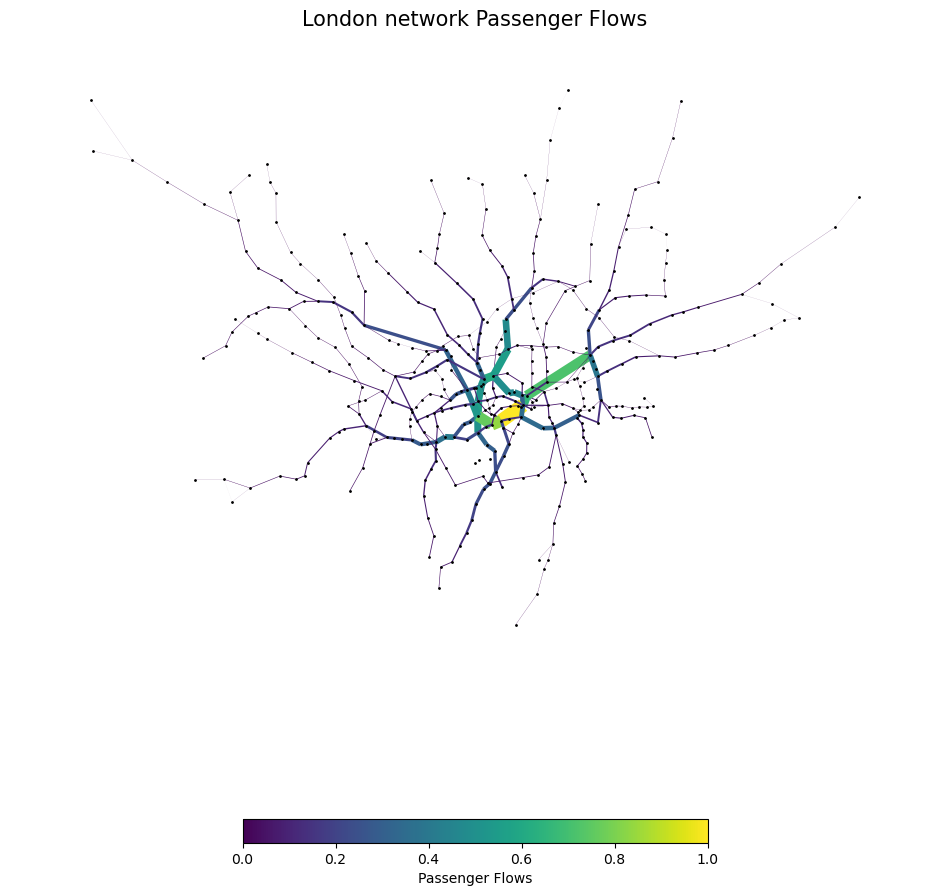

In [43]:
#plot our calcuated flows
flows_values = flows.values()
flow_color=[(i[2]['flows']/max(flows_values)) for i in G.edges(data=True)]
flow_width=[(i[2]['flows']/max(flows_values)*10) for i in G.edges(data=True)]

# Plot graph
fig, ax = plt.subplots(figsize=(12,12))

#pos=nx.spring_layout(X)
edg=nx.draw_networkx_edges(G, pos,edge_color=flow_color, width=flow_width)

nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= 'black',
        node_size= 1)

plt.colorbar(edg,label="Passenger Flows",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London network Passenger Flows",fontsize=15)
plt.show()

# I. Topological Network

In this part, you will evaluate the resilience of the London’s underground through the removal of stations that can potentially make the underground vulnerable. Through the procedure outlined below you will investigate which are the stations that are most critical for the functioning of the underground, and which methodology is more appropriate to finding these stations.

In [44]:
#copy data to avoid disturbing master data
H = G.copy()
print(H)

Graph with 401 nodes and 467 edges


In [50]:
#check the attribute of link
list(H.edges(data = True))[0:1]

[("Earl's Court",
  'Gloucester Road',
  {'length': 910.1212138490864, 'line_name': 'District', 'flows': 85610})]

In [46]:
#check the attribute of node
list(H.nodes(data = True))[0:1]

[("Earl's Court", {'coords': (525466.7699525921, 178494.18714144814)})]

## II.1. Flows: weighted network

In this section, you will include passengers into the underground, and assess whether different measures need to be used when flows are considered. The network to use in this section is the weighted network given to you in the coursework, where the flows of passengers were assigned to the links between stations..

**II.1. Consider the centrality measure derived in I.** indicating the most relevant stations for assessing the vulnerability of the underground. What would you need to do to adjust this measure for a weighted network? Recompute the ranking of the 10 most important nodes according to this adjusted measure. Do you find the same ones as in I.1?

### II.1.1. Degree Centrality (Eigenvector Centrality)

In [53]:
#Let us compute the degree centrality
eigenvector_centrality_w = nx.eigenvector_centrality(H, weight = 'flows', max_iter=1000)

#degree centrality rank
eigenvector_centrality_w_df = pd.DataFrame(index = dict(eigenvector_centrality_w).keys())
eigenvector_centrality_w_df['eigen'] = dict(eigenvector_centrality_w).values()
eigenvector_centrality_w_df.sort_values('eigen', ascending =False, inplace=True)
eigenvector_centrality_w_df.reset_index(inplace=True)
eigenvector_centrality_w_df.rename(columns={'index':'eigen_c_w','degree':'eig_value_w'}, inplace=True)
eigenvector_centrality_w_df = eigenvector_centrality_w_df[:10]
eigenvector_centrality_w_df

,eigen_c_w,eigen
0,Waterloo,0.527246
1,Bank and Monument,0.481800
2,Westminster,0.427583
3,Green Park,0.327679
4,Liverpool Street,0.267516
5,Moorgate,0.142221
6,Oxford Circus,0.136051
7,Stratford,0.126707
8,Bond Street,0.119394
9,Victoria,0.112470


In [54]:
# Let us add the degree data as attribute to the nodes in the graph
# Data needs to be in the form of dictionary, in which nodes are the keys and attibutes are the values.
nx.set_node_attributes(H,dict(eigenvector_centrality_w),'eigen_w')

# To check nodes attributes
list(H.nodes(data=True))[0:1]

[("Earl's Court",
  {'coords': (525466.7699525921, 178494.18714144814),
   'eigen_w': 0.00023401534928149776})]

In [113]:
list(H.edges(data=True))[0:1]

[("Earl's Court",
  'Gloucester Road',
  {'length': 910.1212138490864,
   'line_name': 'District',
   'flows': 85610,
   'v_flows': 1.17e-05})]

### II.1.2. 'Flows' Closeness Centrality

In [61]:
# given that the network is weighted let us introduce the weights.
# as an initial trial, let us see what happens when we include the weights as the strength of the interaction
v_flows = {}
for e1, e2, flows in H.edges(data='flows'):
    if flows != 0:
        v_flows[(e1, e2)] = round(1.0 / flows, 7)
    else:
        v_flows[(e1, e2)] = 0.0 

nx.set_edge_attributes(H, v_flows, 'v_flows')

closeness_centrality_w = nx.closeness_centrality(H, distance='v_flows')

#degree centrality rank
closeness_centrality_w_df = pd.DataFrame(index = dict(closeness_centrality_w).keys())
closeness_centrality_w_df['closeness'] = dict(closeness_centrality_w).values()
closeness_centrality_w_df.sort_values('closeness', ascending =False, inplace=True)
closeness_centrality_w_df.reset_index(inplace=True)
closeness_centrality_w_df.rename(columns={'index':'closeness_c_w','closeness':'clos_value_w'}, inplace=True)
closeness_centrality_w_df = closeness_centrality_w_df[:10]
closeness_centrality_w_df

,closeness_c_w,clos_value_w
0,Green Park,2373.492832
1,Westminster,2366.421427
2,Waterloo,2361.109226
3,Bank and Monument,2357.776004
4,Oxford Circus,2354.617110
5,Bond Street,2342.645937
6,Victoria,2342.281042
7,Liverpool Street,2338.538530
8,Warren Street,2334.094053
9,Moorgate,2318.023560


In [63]:
# Let us add the degree data as attribute to the nodes in the graph
# Data needs to be in the form of dictionary, in which nodes are the keys and attibutes are the values.
nx.set_node_attributes(H,dict(closeness_centrality_w),'closeness_w')

# To check nodes attributes
list(H.nodes(data=True))[0:1]

[("Earl's Court",
  {'coords': (525466.7699525921, 178494.18714144814),
   'eigen_w': 0.00023401534928149776,
   'betweenness_w': 4158.75,
   'closeness_w': 2145.532545314988})]

### II.2.3. Weighted Betweeness Centrality

In [73]:
#Let us compute the betweenness centrality for the network 
betweenness_centrality_w = nx.betweenness_centrality(H, weight = 'v_flows', normalized=False)

#degree centrality rank
betweenness_centrality_w_df = pd.DataFrame(index = dict(betweenness_centrality_w).keys())
betweenness_centrality_w_df['betweenness'] = dict(betweenness_centrality_w).values()
betweenness_centrality_w_df.sort_values('betweenness', ascending =False, inplace=True)
betweenness_centrality_w_df.reset_index(inplace=True)
betweenness_centrality_w_df.rename(columns={'index':'betweenness_c_w','betweenness':'bet_value_w'}, inplace=True)
betweenness_centrality_w_df = betweenness_centrality_w_df[:10]
betweenness_centrality_w_df

,betweenness_c_w,bet_value_w
0,Green Park,44129.75
1,Bank and Monument,35695.50
2,Waterloo,29855.75
3,Westminster,28385.75
4,Liverpool Street,27010.00
5,Stratford,25715.00
6,Euston,22765.75
7,Oxford Circus,21063.50
8,Bond Street,19493.00
9,Warren Street,19358.25


In [56]:
# Let us add the degree data as attribute to the nodes in the graph
# Data needs to be in the form of dictionary, in which nodes are the keys and attibutes are the values.
nx.set_node_attributes(H, dict(betweenness_centrality_w), 'betweenness_w')

# To check nodes attributes
list(H.nodes(data=True))[0:1]

[("Earl's Court",
  {'coords': (525466.7699525921, 178494.18714144814),
   'eigen_w': 0.00023401534928149776,
   'betweenness_w': 4158.75})]

### II.2.3. Top 10 Centrality Rank

In [74]:
#rank table
rank = {'rank':[1,2,3,4,5,6,7,8,9,10]}
rank_df = pd.DataFrame(rank)

rank_df = rank_df.merge(eigenvector_centrality_w_df, left_index=True, right_index=True)
rank_df = rank_df.merge(closeness_centrality_w_df, left_index=True, right_index=True)
rank_df = rank_df.merge(betweenness_centrality_w_df, left_index=True, right_index=True)
rank_df.to_csv('W_rank_df.csv', index=False)
rank_df

,rank,eigen_c_w,eigen,closeness_c_w,clos_value_w,betweenness_c_w,bet_value_w
0,1,Waterloo,0.527246,Green Park,2373.492832,Green Park,44129.75
1,2,Bank and Monument,0.481800,Westminster,2366.421427,Bank and Monument,35695.50
2,3,Westminster,0.427583,Waterloo,2361.109226,Waterloo,29855.75
3,4,Green Park,0.327679,Bank and Monument,2357.776004,Westminster,28385.75
4,5,Liverpool Street,0.267516,Oxford Circus,2354.617110,Liverpool Street,27010.00
5,6,Moorgate,0.142221,Bond Street,2342.645937,Stratford,25715.00
6,7,Oxford Circus,0.136051,Victoria,2342.281042,Euston,22765.75
7,8,Stratford,0.126707,Liverpool Street,2338.538530,Oxford Circus,21063.50
8,9,Bond Street,0.119394,Warren Street,2334.094053,Bond Street,19493.00
9,10,Victoria,0.112470,Moorgate,2318.023560,Warren Street,19358.25


## II.2. Impact measures:

II.2. Now consider the measure for assessing the impact of node removal. Would you adjust themeasure for a weighted network? If yes, how? Propose a different measure that would be better atassessing the impact of closing a station taking into consideration the passengers.

**1. Components**

**2. Average Path Length**

In [119]:
list(H.edges(data=True))[:1]

[("Earl's Court",
  'Gloucester Road',
  {'length': 910.1212138490864,
   'line_name': 'District',
   'flows': 85610,
   'v_flows': 1.17e-05})]

## I.3. Node removal:

In [125]:
#3) for betweenness centrality
def evaluate_impact_after_sequential_removal_bc_uw(G, num_nodes_to_remove=10, stations=None):
    # Initialize lists to store impact measures and removed nodes
    giant_component_sizes = []
    average_path_lengths = []  # List to store average path length after each removal
    num_components = []  # List to store number of connected components after each removal
    removed_nodes = []
    degree_centrality_removed_nodes = []

    # Create a copy of the original graph to perform node removals
    H = G.copy()

    # Sequential removal based on updated centrality rankings after each removal
    for i in range(num_nodes_to_remove):
        # Compute centrality measure for the current graph
        current_centrality = nx.betweenness_centrality(H, weight='v_flows', normalized=False)

        # Get the node with the highest centrality
        node_to_remove = max(current_centrality, key=current_centrality.get)
        removed_nodes.append(node_to_remove)
        
        # Record degree centrality of removed node
        degree_centrality_removed_nodes.append(current_centrality[node_to_remove])

        # Remove the selected node
        H.remove_node(node_to_remove)

        # 1) Compute giant component size (largest connected component)
        giant_component = max(nx.connected_components(H), key=len)
        giant_component_size = len(giant_component)
        giant_component_sizes.append(giant_component_size)

        # 2) Compute average shortest path length in the giant component
        if giant_component_size > 1:
            subgraph = H.subgraph(giant_component)
            avg_path_length = nx.average_shortest_path_length(subgraph, weight='flows')
        else:
            avg_path_length = 0
        average_path_lengths.append(avg_path_length)

        # 3) Compute number of connected components
        num_comp = nx.number_connected_components(H)
        num_components.append(num_comp)

    return giant_component_sizes, average_path_lengths, num_components, removed_nodes, degree_centrality_removed_nodes

# Evaluate impact of node removal using Sequential Removal
giant_component_sizes_B_bc_w, avg_path_lengths_B_bc_w, num_components_B_bc_w, removed_nodes_B_bc_w, degree_centrality_removed_nodes_B_bc_w = evaluate_impact_after_sequential_removal_bc_uw(H, num_nodes_to_remove=3, stations=stations)
        

In [126]:
avg_path_lengths_B_bc_w

[259313.58807017544, 263619.9022430448, 272453.8524106679]

### II.3.1. Node removal for Strategic B: Sequential, for Betweenness Centrality

### I.3.3. Effectiveness Comparison

In [456]:
# Evaluate impact of node removal using Non-sequential Removal (Strategy A)
giant_component_sizes_A_dc_uw, avg_path_lengths_A_dc_uw, num_components_A_dc_uw, removed_nodes_A_dc_uw, rank_df['deg_value_uw']
giant_component_sizes_A_cc_uw, avg_path_lengths_A_cc_uw, num_components_A_cc_uw, removed_nodes_A_cc_uw, rank_df['clos_value_uw']
giant_component_sizes_A_bc_uw, avg_path_lengths_A_bc_uw, num_components_A_bc_uw, removed_nodes_A_bc_uw, rank_df['bet_value_uw']

giant_component_sizes_B_dc_uw, avg_path_lengths_B_dc_uw, num_components_B_dc_uw, removed_nodes_B_dc_uw, degree_centrality_removed_nodes_B_dc_uw
giant_component_sizes_B_cc_uw, avg_path_lengths_B_cc_uw, num_components_B_cc_uw, removed_nodes_B_cc_uw, degree_centrality_removed_nodes_B_cc_uw
giant_component_sizes_B_bc_uw, avg_path_lengths_B_bc_uw, num_components_B_bc_uw, removed_nodes_B_bc_uw, degree_centrality_removed_nodes_B_bc_uw

([379, 378, 377, 376, 375, 227, 226, 196, 173, 170],
 [14.496447069006436,
  15.31013431013431,
  15.795939387098596,
  16.789631205673757,
  19.02923351158645,
  13.4623601419048,
  14.20645034414946,
  13.792046049188906,
  13.821884661916924,
  18.193595544726765],
 [3, 3, 3, 3, 3, 4, 4, 5, 6, 7],
 ['Stratford',
  "King's Cross St. Pancras",
  'Waterloo',
  'Bank and Monument',
  'Canada Water',
  'West Hampstead',
  "Earl's Court",
  "Shepherd's Bush",
  'Euston',
  'Baker Street'],
 [23768.093434343453,
  19632.883549783513,
  20080.980759591308,
  16872.84920634919,
  19153.84166666666,
  35548.31825396828,
  7446.480158730154,
  9925.222222222228,
  6673.092023172902,
  7505.333333333332])

In [100]:
# 1. Giant Component Size: create iteration df
iteration_GCS = {
    'iteration':[1,2,3,4,5,6,7,8,9,10],
    'A_dc_uw':giant_component_sizes_A_dc_uw,
    'A_cc_uw':giant_component_sizes_A_cc_uw,
    'A_bc_uw':giant_component_sizes_A_bc_uw,
    'B_dc_uw':giant_component_sizes_B_dc_uw,
    'B_cc_uw':giant_component_sizes_B_cc_uw,
    'B_bc_uw':giant_component_sizes_B_bc_uw}

iteration_GCS_df = pd.DataFrame(iteration_GCS)
iteration_GCS_df

NameError: name 'giant_component_sizes_A_dc_uw' is not defined

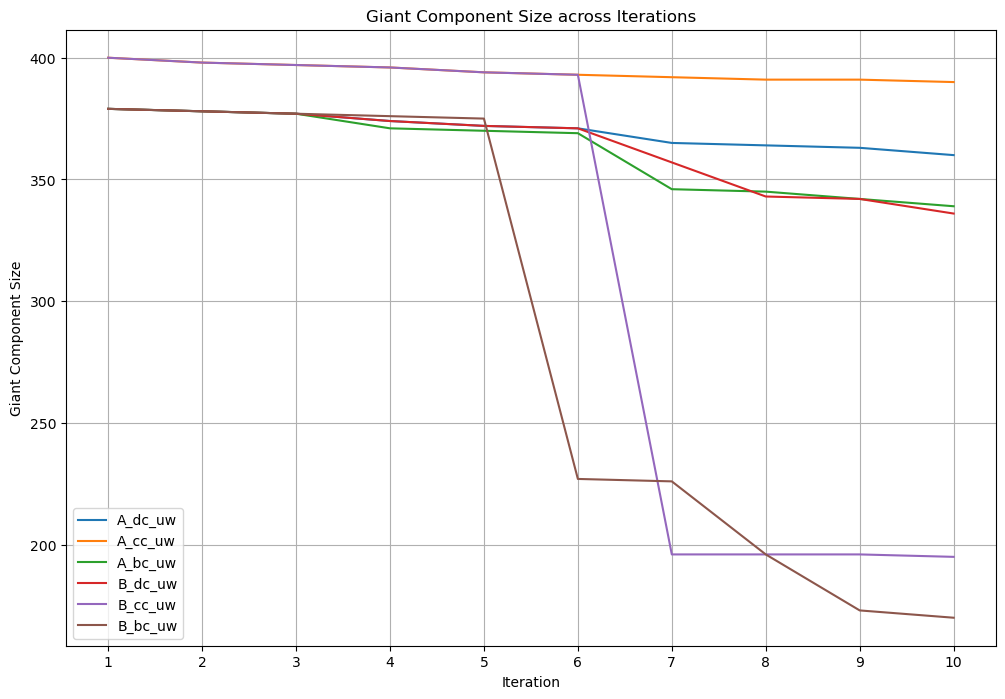

In [474]:
# Plotting the line graph
plt.figure(figsize=(12, 8))

# Plot lines for each centrality measure
plt.plot(iteration_GCS_df['iteration'], iteration_GCS_df['A_dc_uw'], label='A_dc_uw')
plt.plot(iteration_GCS_df['iteration'], iteration_GCS_df['A_cc_uw'], label='A_cc_uw')
plt.plot(iteration_GCS_df['iteration'], iteration_GCS_df['A_bc_uw'], label='A_bc_uw')
plt.plot(iteration_GCS_df['iteration'], iteration_GCS_df['B_dc_uw'], label='B_dc_uw')
plt.plot(iteration_GCS_df['iteration'], iteration_GCS_df['B_cc_uw'], label='B_cc_uw')
plt.plot(iteration_GCS_df['iteration'], iteration_GCS_df['B_bc_uw'], label='B_bc_uw')

# Customize plot labels and title
plt.title('Giant Component Size across Iterations')
plt.xlabel('Iteration')
plt.ylabel('Giant Component Size')
plt.xticks(iteration_GCS_df['iteration'])  # Set x-axis ticks to iteration numbers
plt.legend()  # Show legend

plt.grid(True)  # Add grid for better readability
plt.savefig(f"UW_Giant Component Size across Iterations and Across Centrality.png")

plt.show()

In [459]:
# 2. Giant Component Size: create iteration df
iteration_APL = {
    'iteration':[1,2,3,4,5,6,7,8,9,10],
    'A_dc_uw':avg_path_lengths_A_dc_uw,
    'A_cc_uw':avg_path_lengths_A_cc_uw,
    'A_bc_uw':avg_path_lengths_A_bc_uw,
    'B_dc_uw':avg_path_lengths_B_dc_uw,
    'B_cc_uw':avg_path_lengths_B_cc_uw,
    'B_bc_uw':avg_path_lengths_B_bc_uw}

iteration_APL_df = pd.DataFrame(iteration_APL)
iteration_APL_df

,iteration,A_dc_uw,A_cc_uw,A_bc_uw,B_dc_uw,B_cc_uw,B_bc_uw
0,1,14.496447,13.584787,14.496447,14.496447,13.584787,14.496447
1,2,14.872497,14.298115,14.872497,14.872497,14.298115,15.310134
2,3,15.686438,14.316592,15.031209,15.686438,14.349439,15.795939
3,4,17.013376,14.968482,16.030742,17.013376,15.940366,16.789631
4,5,17.193882,15.000969,16.756742,17.193882,16.873587,19.029234
5,6,17.786581,15.024679,17.180865,17.557150,19.320702,13.462360
6,7,17.778940,15.043831,16.807372,17.897004,12.486028,14.206450
7,8,18.185421,15.060463,16.975059,19.832148,12.486028,13.792046
8,9,18.324780,15.060463,17.586339,20.859495,12.486028,13.821885
9,10,19.020396,15.102498,17.986979,21.105117,12.936030,18.193596


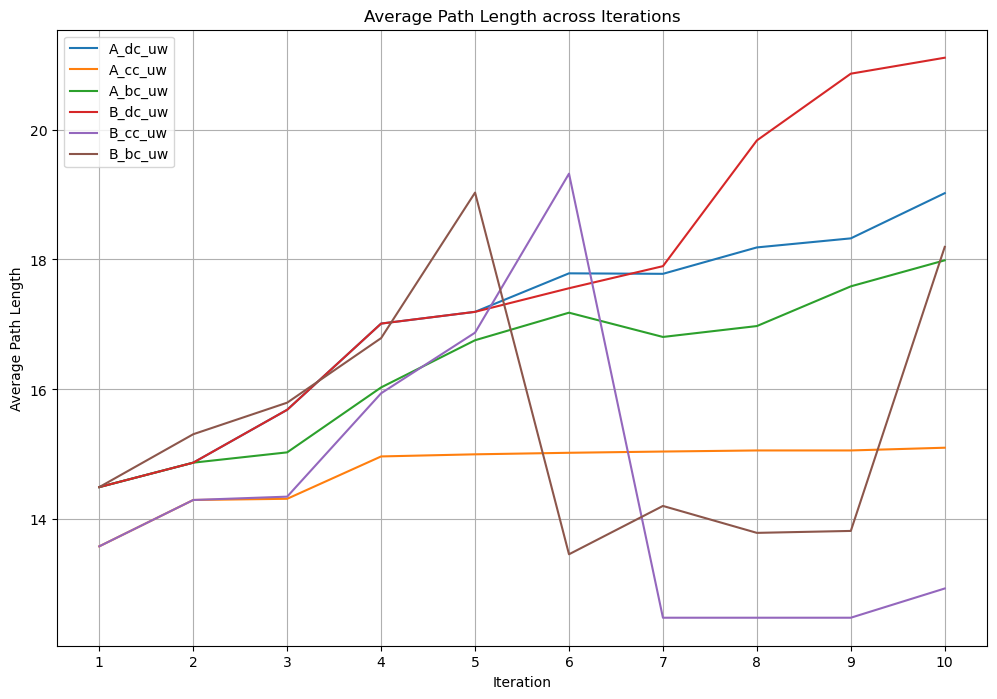

In [473]:
# Plotting the line graph
plt.figure(figsize=(12, 8))

# Plot lines for each centrality measure
plt.plot(iteration_APL_df['iteration'], iteration_APL_df['A_dc_uw'], label='A_dc_uw')
plt.plot(iteration_APL_df['iteration'], iteration_APL_df['A_cc_uw'], label='A_cc_uw')
plt.plot(iteration_APL_df['iteration'], iteration_APL_df['A_bc_uw'], label='A_bc_uw')
plt.plot(iteration_APL_df['iteration'], iteration_APL_df['B_dc_uw'], label='B_dc_uw')
plt.plot(iteration_APL_df['iteration'], iteration_APL_df['B_cc_uw'], label='B_cc_uw')
plt.plot(iteration_APL_df['iteration'], iteration_APL_df['B_bc_uw'], label='B_bc_uw')

# Customize plot labels and title
plt.title('Average Path Length across Iterations')
plt.xlabel('Iteration')
plt.ylabel('Average Path Length')
plt.xticks(iteration_APL_df['iteration'])  # Set x-axis ticks to iteration numbers
plt.legend()  # Show legend

plt.grid(True)  # Add grid for better readability
plt.savefig(f"UW_Average Path Length across Iterations and Across Centrality.png")

plt.show()

- Best centrality measure: **betweeness centrality**
- Best strategy: **B-Sequential**
- Best global measurement: **Components & Average Path Length**

### I.3.4. In-depth Analysis for Sequential Betweenness Centrality in Components & Average Path Length

In [128]:
# 2. Comprehensive Table for SBC
iteration_SBC = {
    'iteration':[1,2,3],
    'node_removed':removed_nodes_B_bc_w,
    'bc_score': np.round(degree_centrality_removed_nodes_B_bc_w,2),
    'big_component_size':giant_component_sizes_B_bc_w,
    'num_component': num_components_B_bc_w,
    'average_path_length':np.round(avg_path_lengths_B_bc_w,2)}

iteration_SBC_df = pd.DataFrame(iteration_SBC)

#iteration_SBC_df.to_csv('S_BC_W_iteration_SBC.csv', index=False)
iteration_SBC_df

,iteration,node_removed,bc_score,big_component_size,num_component,average_path_length
0,1,Green Park,44129.75,400,1,259313.59
1,2,King's Cross St. Pancras,43631.50,399,1,263619.90
2,3,Bank and Monument,47478.00,398,1,272453.85


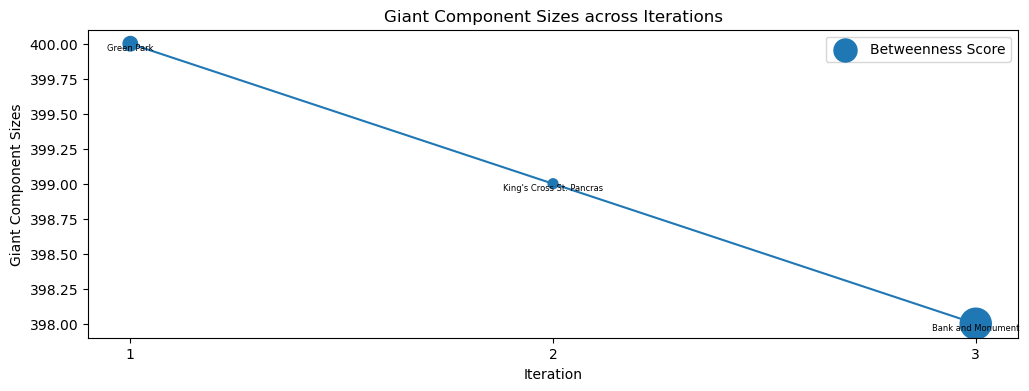

In [134]:
bc_normalized = np.interp(iteration_SBC_df['bc_score'], (min(iteration_SBC_df['bc_score']), max(iteration_SBC_df['bc_score'])), (50, 500))


# Plotting the line graph
plt.figure(figsize=(12, 4))

# Plot lines for each centrality measure
plt.plot(iteration_SBC_df['iteration'], iteration_SBC_df['big_component_size'])
plt.scatter(iteration_SBC_df['iteration'], iteration_SBC_df['big_component_size'], s=bc_normalized, label='Betweenness Score')

for i, name in enumerate(iteration_SBC_df['node_removed']):
    plt.annotate(name, (iteration_SBC_df['iteration'][i], 
                        iteration_SBC_df['big_component_size'][i]), 
                 textcoords="offset points", 
                 xytext=(0,-5), 
                 ha='center', 
                 fontsize=6, 
                 rotation=0)

# Customize plot labels and title
plt.title('Giant Component Sizes across Iterations')
plt.xlabel('Iteration')
plt.ylabel('Giant Component Sizes')
plt.xticks(iteration_SBC_df['iteration'])  # Set x-axis ticks to iteration numbers
plt.legend()  # Show legend

plt.grid(False)  # Add grid for better readability
plt.savefig(f"S_BC_W_Giant Component Sizes across Iterations.png")

plt.show()


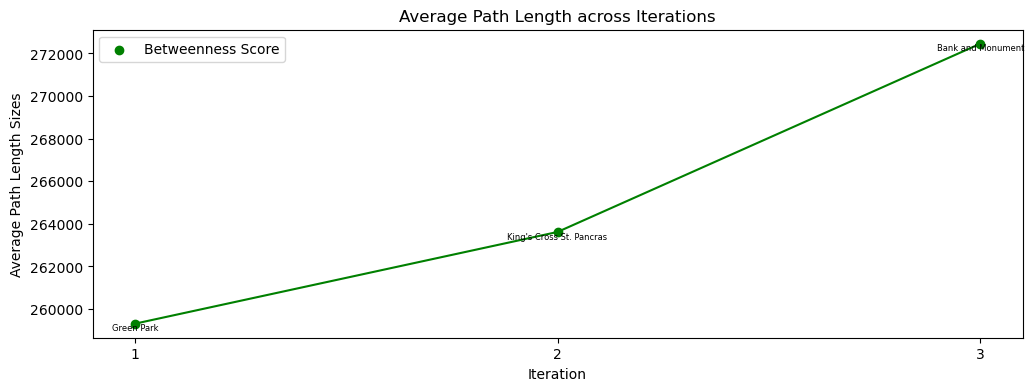

In [135]:
# Plotting the line graph
plt.figure(figsize=(12, 4))

# Plot lines for each centrality measure
plt.plot(iteration_SBC_df['iteration'], iteration_SBC_df['average_path_length'], color='green')
plt.scatter(iteration_SBC_df['iteration'], iteration_SBC_df['average_path_length'], label='Betweenness Score', color='green')

for i, name in enumerate(iteration_SBC_df['node_removed']):
    plt.annotate(name, (iteration_SBC_df['iteration'][i], 
                        iteration_SBC_df['average_path_length'][i]), 
                 textcoords="offset points", 
                 xytext=(0,-5), 
                 ha='center', 
                 fontsize=6, 
                 rotation=0)

# Customize plot labels and title
plt.title('Average Path Length across Iterations')
plt.xlabel('Iteration')
plt.ylabel('Average Path Length Sizes')
plt.xticks(iteration_SBC_df['iteration'])  # Set x-axis ticks to iteration numbers
plt.legend()  # Show legend

plt.savefig(f"S_BC_W_Average Path Length across Iterations.png")

plt.grid(False)  # Add grid for better readability
plt.show()

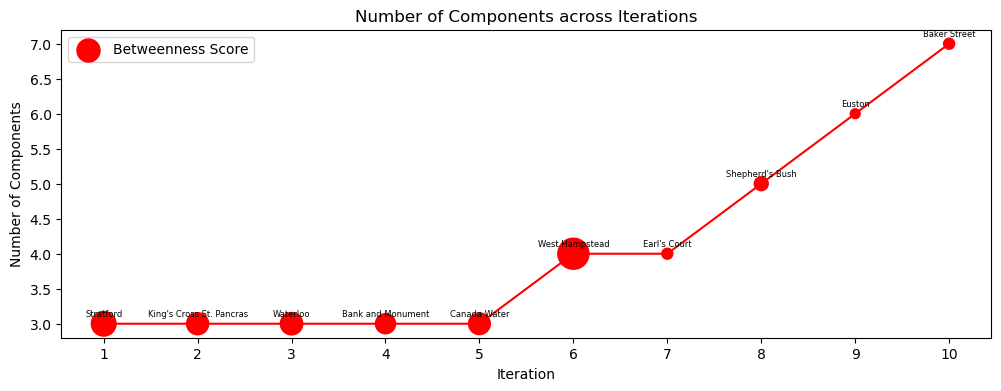

In [468]:
# Plotting the line graph
plt.figure(figsize=(12, 4))

# Plot lines for each centrality measure
plt.plot(iteration_SBC_df['iteration'], iteration_SBC_df['num_component'], color='red')
plt.scatter(iteration_SBC_df['iteration'], iteration_SBC_df['num_component'], s=bc_normalized, label='Betweenness Score', color='red')

for i, name in enumerate(iteration_SBC_df['node_removed']):
    plt.annotate(name, (iteration_SBC_df['iteration'][i], 
                        iteration_SBC_df['num_component'][i]), 
                 textcoords="offset points", 
                 xytext=(0,5), 
                 ha='center', 
                 fontsize=6, 
                 rotation=0)

# Customize plot labels and title
plt.title('Number of Components across Iterations')
plt.xlabel('Iteration')
plt.ylabel('Number of Components')
plt.xticks(iteration_APL_df['iteration'])  # Set x-axis ticks to iteration numbers
plt.legend()  # Show legend

plt.savefig(f"S_BC_UW_Number of Components across Iterations.png")

plt.grid(False)  # Add grid for better readability
plt.show()

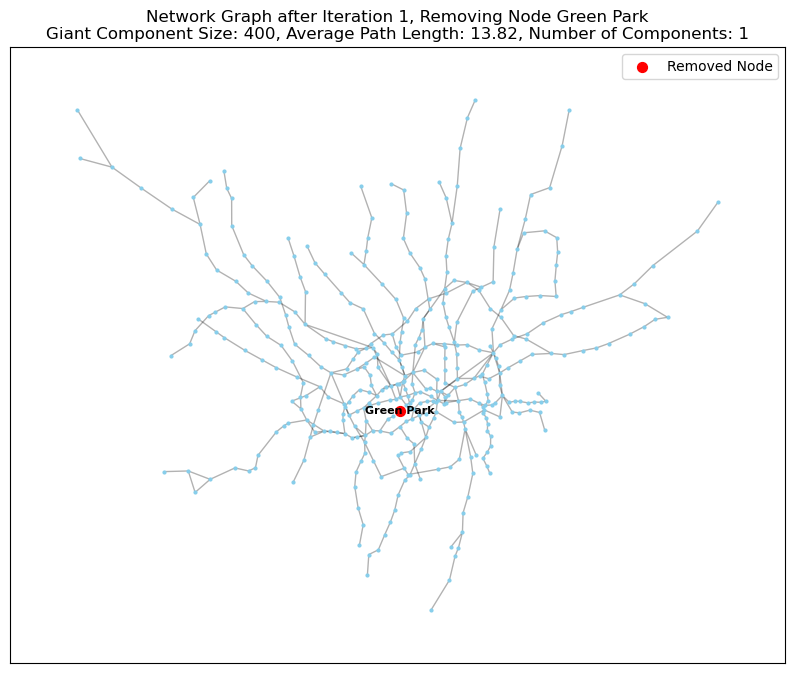

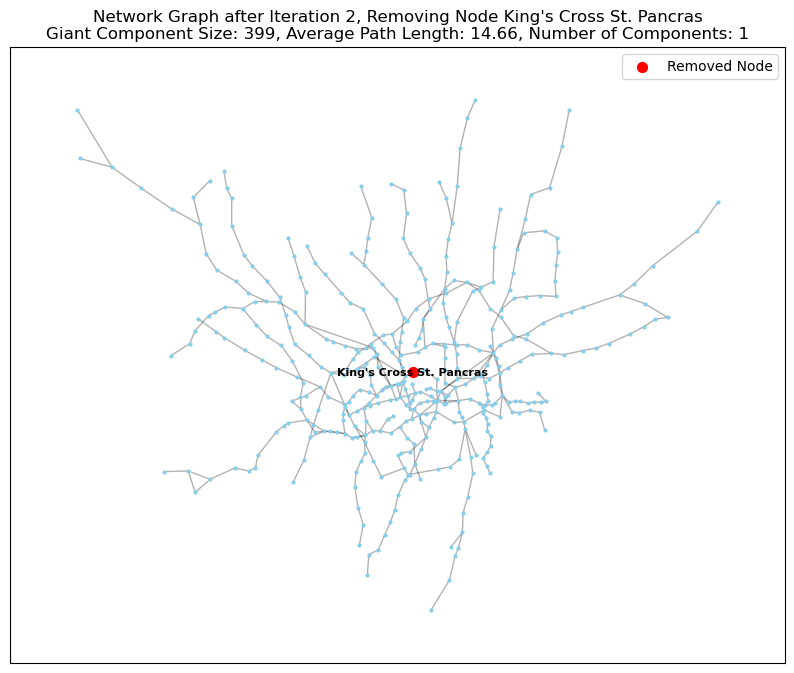

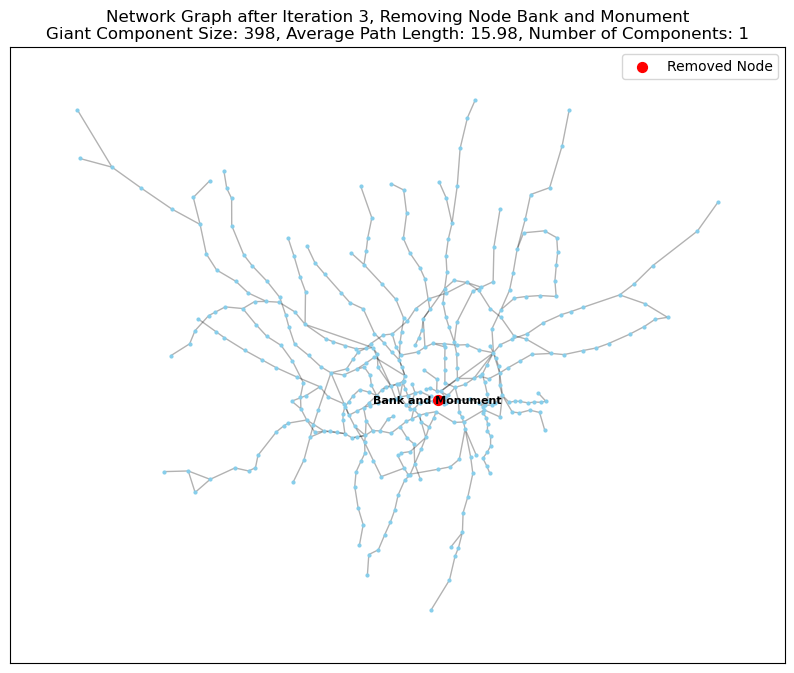

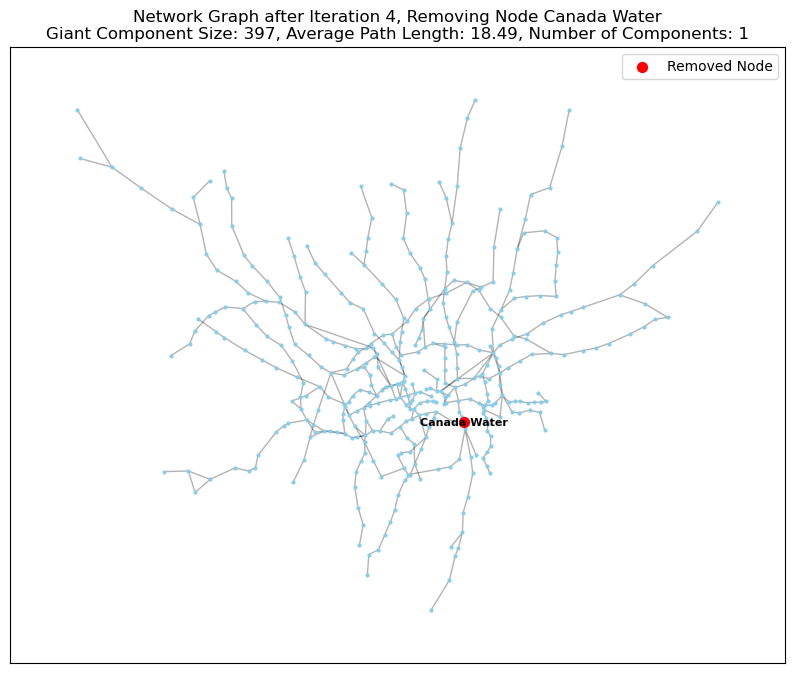

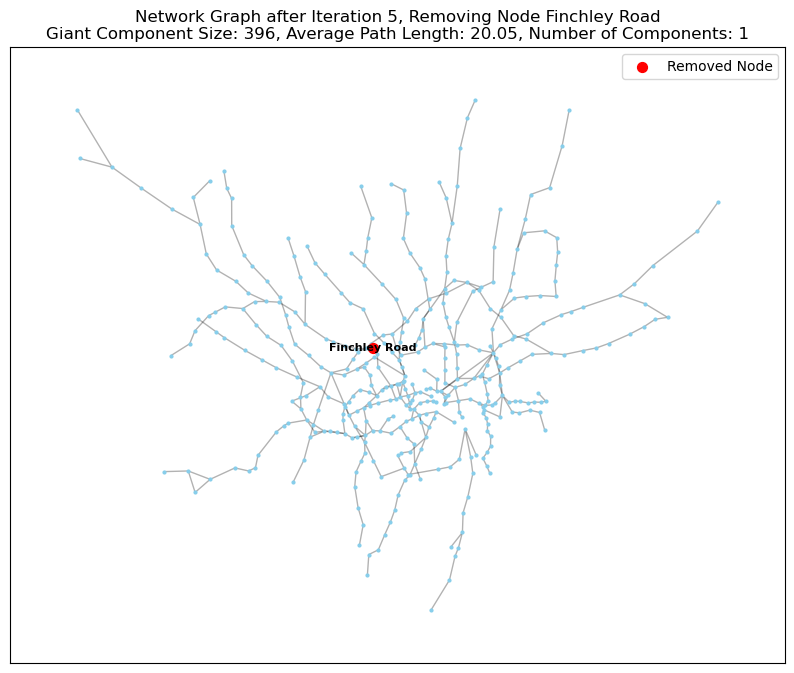

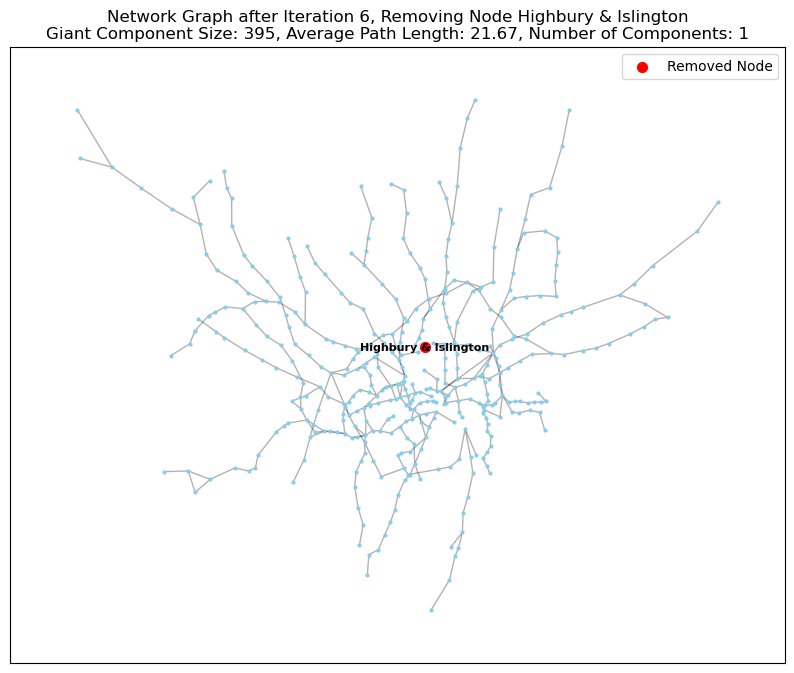

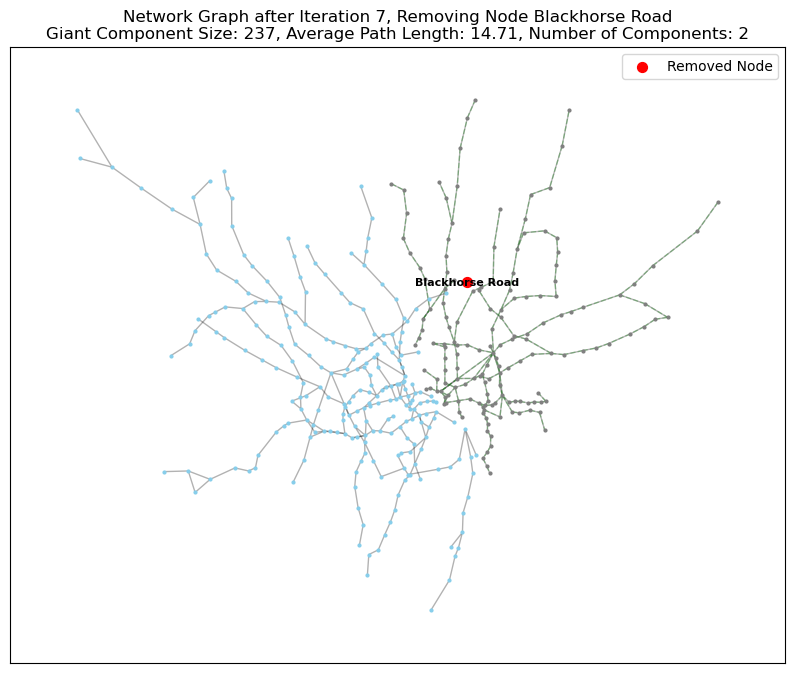

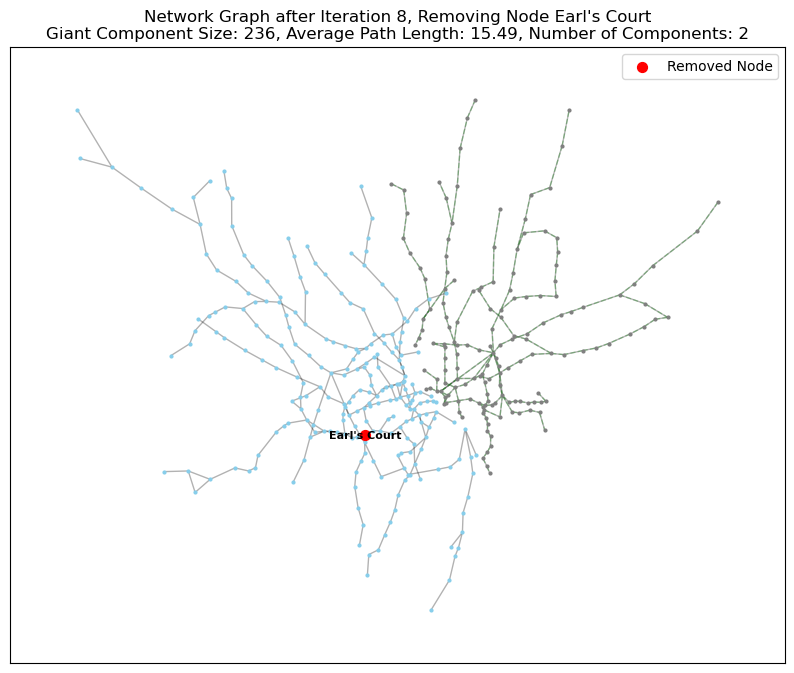

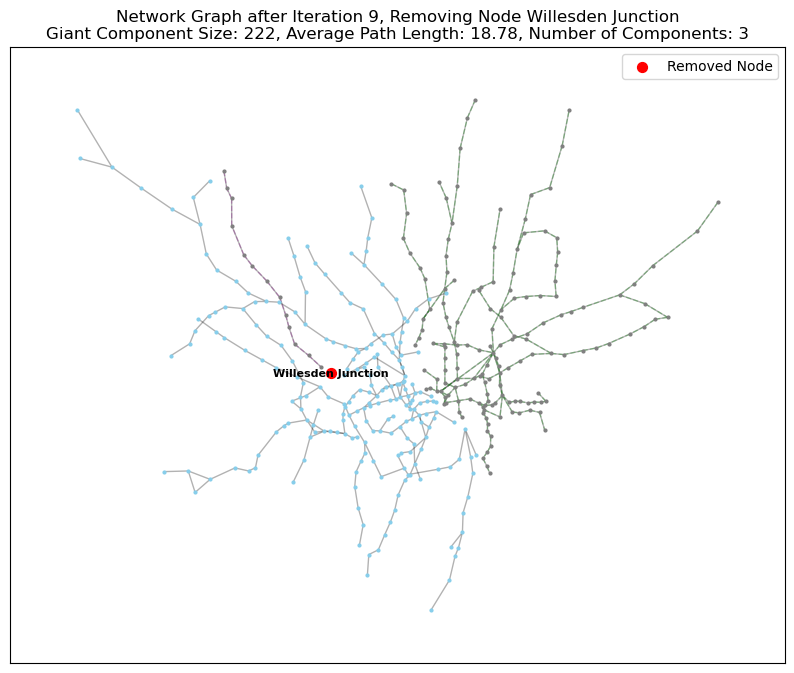

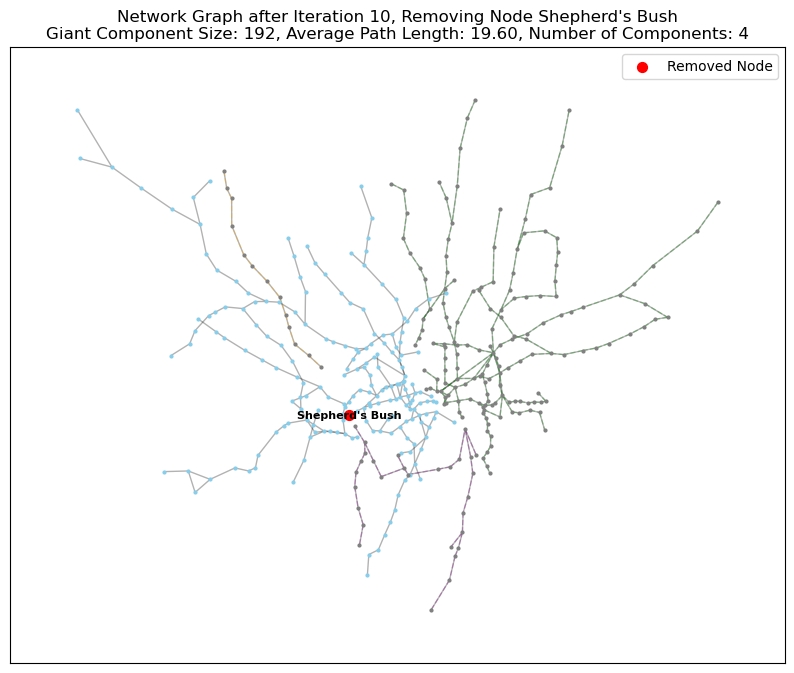

In [85]:
def evaluate_impact_after_sequential_removal_bc_w(G, num_nodes_to_remove=10):
    # Initialize lists to store impact measures and removed nodes
    giant_component_sizes = []
    average_path_lengths = []
    num_components = []
    removed_nodes = []
    degree_centrality_removed_nodes = []

    # Create a copy of the original graph to perform node removals
    H = G.copy()

    # Prepare station positions for visualization
    pos = {row['name']: row.geometry.coords[0] for _, row in stations.iterrows() if row['name'] in H.nodes()}

    # Sequential removal based on updated centrality rankings after each removal
    for i in range(num_nodes_to_remove):
        # Compute betweenness centrality for the current graph
        current_centrality = nx.betweenness_centrality(H, weight='v_flows', normalized=False)

        # Get the node with the highest centrality
        node_to_remove = max(current_centrality.items(), key=lambda x: x[1])[0]
        removed_nodes.append(node_to_remove)
        
        # Record degree centrality of removed node
        degree_centrality_removed_nodes.append(current_centrality[node_to_remove])

        # Remove the selected node
        H.remove_node(node_to_remove)

        # Compute giant component size (largest connected component)
        giant_component = max(nx.connected_components(H), key=len)
        giant_component_size = len(giant_component)
        giant_component_sizes.append(giant_component_size)

        # Compute average shortest path length in the giant component
        if giant_component_size > 1:
            subgraph = H.subgraph(giant_component)
            avg_path_length = nx.average_shortest_path_length(subgraph)
        else:
            avg_path_length = 0
        average_path_lengths.append(avg_path_length)

        # Compute number of connected components
        num_comp = nx.number_connected_components(H)
        num_components.append(num_comp)

        # Visualize the network graph after node removal
        plt.figure(figsize=(10, 8))
        plt.title(f'Network Graph after Iteration {i+1}, Removing Node {node_to_remove}\nGiant Component Size: {giant_component_size}, Average Path Length: {avg_path_length:.2f}, Number of Components: {num_comp}')

         # Draw nodes and edges of the largest connected component
        nx.draw_networkx_nodes(H, pos=pos, nodelist=giant_component, node_size=4, node_color='skyblue')
        nx.draw_networkx_edges(H, pos=pos, edgelist=H.edges(), alpha=0.3)
        
        # Highlight the removed node as red and add label
        nx.draw_networkx_nodes(H, pos=pos, nodelist=[node_to_remove], node_size=50, node_color='red', label='Removed Node')
        nx.draw_networkx_labels(H, pos=pos, labels={node_to_remove: node_to_remove}, font_size=8, font_color='black', font_weight='bold')

        # Highlight disconnected components with different colors and as dashed lines
        component_colors = ['red', 'green', 'purple', 'orange', 'pink']  # Define colors for components
        for idx, component in enumerate(nx.connected_components(H)):
            if component != giant_component:
                nx.draw_networkx_nodes(H, pos=pos, nodelist=component, node_size=4, node_color='gray')
                nx.draw_networkx_edges(H, pos=pos, edgelist=H.subgraph(component).edges(), alpha=0.3, style='dashed', edge_color=component_colors[idx % len(component_colors)])

        # Save the current figure
        plt.savefig(f"disconnected iteration_{i+1} - unweighted.png")
        plt.legend()
        plt.show()

# Replace 'H' with your graph and adjust parameters as needed
evaluate_impact_after_sequential_removal_bc_w(H, num_nodes_to_remove=10)